In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [3]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
import seaborn as sns
from pathlib import Path
import warnings

In [4]:
data_dir = Path('./data/')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 10
n_class = 3
seed = 42

In [5]:
algo_name = 'lgbcv_last1'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = data_dir / f'{feature_name}.csv'
p_val_file = data_dir / f'{model_name}.val.csv'
p_tst_file = data_dir / f'{model_name}.tst.csv'
sub_file = data_dir / f'{model_name}.csv'

In [6]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 25)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,...,d_dered_zi,d_dered_zr,d_dered_zg,d_dered_zu,d_dered_ir,d_dered_ig,d_dered_iu,d_dered_ru,d_dered_gu,d_obs_det
id,,,,,,,,,,,,,,,,,,,,,
0,16.939607,-0.000081,23.12426,20.25779,18.95512,17.63211,16.90894,2.944439,1.189764,0.0,...,-0.72317,-2.04618,-3.34885,-6.21532,-1.32301,-2.62568,-5.49215,-4.16914,-2.86647,6.113219
1,13.168941,0.004506,14.96642,14.00452,13.41139,13.23625,13.13468,0.693147,1.253254,1.0,...,-0.10157,-0.27671,-0.86984,-1.83174,-0.17514,-0.76827,-1.73017,-1.55503,-0.96190,1.442695
2,15.350032,0.000472,16.60765,15.68659,15.44004,15.32173,15.29608,1.098612,1.022499,0.0,...,-0.02565,-0.14396,-0.39051,-1.31157,-0.11831,-0.36486,-1.28592,-1.16761,-0.92106,1.820478
3,19.634649,0.000006,25.35365,20.99465,20.08727,19.79465,19.55518,1.609438,1.205399,0.0,...,-0.23947,-0.53209,-1.43947,-5.79847,-0.29262,-1.20000,-5.55900,-5.26638,-4.35900,1.864005
4,17.982649,-0.000033,23.77140,20.43384,18.86299,18.19028,17.87592,2.639057,1.193946,0.0,...,-0.31436,-0.98707,-2.55792,-5.89548,-0.67271,-2.24356,-5.58112,-4.90841,-3.33756,4.547078


In [7]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 24) (80000, 24)


# LGBM 첫번째 예측

In [8]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [9]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             boosting_type='gbdt',
                             n_estimators=16608,
                             max_depth=30,
                             num_iterations=14278,
                             num_leaves=138,
                             learning_rate=0.02,
                             min_child_samples=255,
                             subsample=.6,
                             subsample_freq=1,
                             colsample_bytree=.9,
                             random_state=42,
                             n_jobs=-1)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=100)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1


c:\users\82102\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 0.955476
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.926594
[3]	valid_0's multi_logloss: 0.899254
[4]	valid_0's multi_logloss: 0.874887
[5]	valid_0's multi_logloss: 0.850197
[6]	valid_0's multi_logloss: 0.826671
[7]	valid_0's multi_logloss: 0.806385
[8]	valid_0's multi_logloss: 0.784862
[9]	valid_0's multi_logloss: 0.764302
[10]	valid_0's multi_logloss: 0.744659
[11]	valid_0's multi_logloss: 0.726923
[12]	valid_0's multi_logloss: 0.708793
[13]	valid_0's multi_logloss: 0.692479
[14]	valid_0's multi_logloss: 0.675725
[15]	valid_0's multi_logloss: 0.659598
[16]	valid_0's multi_logloss: 0.644157
[17]	valid_0's multi_logloss: 0.629337
[18]	valid_0's multi_logloss: 0.615061
[19]	valid_0's multi_logloss: 0.601378
[20]	valid_0's multi_logloss: 0.588177
[21]	valid_0's multi_logloss: 0.575406
[22]	valid_0's multi_logloss: 0.56315
[23]	valid_0's multi_logloss: 0.551286
[24]	valid_0's multi_logloss: 0.540001
[25]	valid_0

[208]	valid_0's multi_logloss: 0.163161
[209]	valid_0's multi_logloss: 0.16303
[210]	valid_0's multi_logloss: 0.16291
[211]	valid_0's multi_logloss: 0.162784
[212]	valid_0's multi_logloss: 0.162661
[213]	valid_0's multi_logloss: 0.162529
[214]	valid_0's multi_logloss: 0.162405
[215]	valid_0's multi_logloss: 0.162298
[216]	valid_0's multi_logloss: 0.162193
[217]	valid_0's multi_logloss: 0.16207
[218]	valid_0's multi_logloss: 0.161953
[219]	valid_0's multi_logloss: 0.161827
[220]	valid_0's multi_logloss: 0.161715
[221]	valid_0's multi_logloss: 0.161602
[222]	valid_0's multi_logloss: 0.161507
[223]	valid_0's multi_logloss: 0.161401
[224]	valid_0's multi_logloss: 0.161302
[225]	valid_0's multi_logloss: 0.161201
[226]	valid_0's multi_logloss: 0.161107
[227]	valid_0's multi_logloss: 0.161008
[228]	valid_0's multi_logloss: 0.160914
[229]	valid_0's multi_logloss: 0.160807
[230]	valid_0's multi_logloss: 0.160716
[231]	valid_0's multi_logloss: 0.160621
[232]	valid_0's multi_logloss: 0.160534
[23

[416]	valid_0's multi_logloss: 0.154035
[417]	valid_0's multi_logloss: 0.154034
[418]	valid_0's multi_logloss: 0.154035
[419]	valid_0's multi_logloss: 0.154015
[420]	valid_0's multi_logloss: 0.15401
[421]	valid_0's multi_logloss: 0.153993
[422]	valid_0's multi_logloss: 0.15399
[423]	valid_0's multi_logloss: 0.153979
[424]	valid_0's multi_logloss: 0.15397
[425]	valid_0's multi_logloss: 0.153964
[426]	valid_0's multi_logloss: 0.153953
[427]	valid_0's multi_logloss: 0.153945
[428]	valid_0's multi_logloss: 0.153955
[429]	valid_0's multi_logloss: 0.153947
[430]	valid_0's multi_logloss: 0.153945
[431]	valid_0's multi_logloss: 0.153949
[432]	valid_0's multi_logloss: 0.153933
[433]	valid_0's multi_logloss: 0.153921
[434]	valid_0's multi_logloss: 0.153896
[435]	valid_0's multi_logloss: 0.153885
[436]	valid_0's multi_logloss: 0.153875
[437]	valid_0's multi_logloss: 0.153867
[438]	valid_0's multi_logloss: 0.153857
[439]	valid_0's multi_logloss: 0.153848
[440]	valid_0's multi_logloss: 0.15383
[441

[622]	valid_0's multi_logloss: 0.153487
[623]	valid_0's multi_logloss: 0.153493
[624]	valid_0's multi_logloss: 0.153506
[625]	valid_0's multi_logloss: 0.153509
[626]	valid_0's multi_logloss: 0.153513
[627]	valid_0's multi_logloss: 0.153516
[628]	valid_0's multi_logloss: 0.153511
[629]	valid_0's multi_logloss: 0.153507
[630]	valid_0's multi_logloss: 0.15351
[631]	valid_0's multi_logloss: 0.153498
[632]	valid_0's multi_logloss: 0.153494
[633]	valid_0's multi_logloss: 0.153487
[634]	valid_0's multi_logloss: 0.1535
[635]	valid_0's multi_logloss: 0.153493
[636]	valid_0's multi_logloss: 0.153489
[637]	valid_0's multi_logloss: 0.153493
[638]	valid_0's multi_logloss: 0.1535
[639]	valid_0's multi_logloss: 0.153506
[640]	valid_0's multi_logloss: 0.153506
[641]	valid_0's multi_logloss: 0.153507
[642]	valid_0's multi_logloss: 0.153511
[643]	valid_0's multi_logloss: 0.153523
[644]	valid_0's multi_logloss: 0.153524
[645]	valid_0's multi_logloss: 0.15351
[646]	valid_0's multi_logloss: 0.153511
[647]	

c:\users\82102\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 0.955469
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.926714
[3]	valid_0's multi_logloss: 0.899489
[4]	valid_0's multi_logloss: 0.875212
[5]	valid_0's multi_logloss: 0.850489
[6]	valid_0's multi_logloss: 0.826993
[7]	valid_0's multi_logloss: 0.806751
[8]	valid_0's multi_logloss: 0.785254
[9]	valid_0's multi_logloss: 0.764766
[10]	valid_0's multi_logloss: 0.745206
[11]	valid_0's multi_logloss: 0.727557
[12]	valid_0's multi_logloss: 0.709492
[13]	valid_0's multi_logloss: 0.693245
[14]	valid_0's multi_logloss: 0.676536
[15]	valid_0's multi_logloss: 0.660485
[16]	valid_0's multi_logloss: 0.645074
[17]	valid_0's multi_logloss: 0.630231
[18]	valid_0's multi_logloss: 0.615958
[19]	valid_0's multi_logloss: 0.602289
[20]	valid_0's multi_logloss: 0.589147
[21]	valid_0's multi_logloss: 0.576379
[22]	valid_0's multi_logloss: 0.564148
[23]	valid_0's multi_logloss: 0.552293
[24]	valid_0's multi_logloss: 0.541074
[25]	valid_

[210]	valid_0's multi_logloss: 0.164054
[211]	valid_0's multi_logloss: 0.163912
[212]	valid_0's multi_logloss: 0.163783
[213]	valid_0's multi_logloss: 0.163647
[214]	valid_0's multi_logloss: 0.163523
[215]	valid_0's multi_logloss: 0.163407
[216]	valid_0's multi_logloss: 0.163281
[217]	valid_0's multi_logloss: 0.163171
[218]	valid_0's multi_logloss: 0.163051
[219]	valid_0's multi_logloss: 0.162923
[220]	valid_0's multi_logloss: 0.16282
[221]	valid_0's multi_logloss: 0.16271
[222]	valid_0's multi_logloss: 0.162589
[223]	valid_0's multi_logloss: 0.16249
[224]	valid_0's multi_logloss: 0.162383
[225]	valid_0's multi_logloss: 0.162295
[226]	valid_0's multi_logloss: 0.162171
[227]	valid_0's multi_logloss: 0.162087
[228]	valid_0's multi_logloss: 0.161981
[229]	valid_0's multi_logloss: 0.161873
[230]	valid_0's multi_logloss: 0.161795
[231]	valid_0's multi_logloss: 0.161684
[232]	valid_0's multi_logloss: 0.161594
[233]	valid_0's multi_logloss: 0.161514
[234]	valid_0's multi_logloss: 0.161444
[23

[417]	valid_0's multi_logloss: 0.155383
[418]	valid_0's multi_logloss: 0.155375
[419]	valid_0's multi_logloss: 0.155365
[420]	valid_0's multi_logloss: 0.155369
[421]	valid_0's multi_logloss: 0.15535
[422]	valid_0's multi_logloss: 0.155347
[423]	valid_0's multi_logloss: 0.155334
[424]	valid_0's multi_logloss: 0.155314
[425]	valid_0's multi_logloss: 0.155295
[426]	valid_0's multi_logloss: 0.155279
[427]	valid_0's multi_logloss: 0.155282
[428]	valid_0's multi_logloss: 0.155276
[429]	valid_0's multi_logloss: 0.155263
[430]	valid_0's multi_logloss: 0.155258
[431]	valid_0's multi_logloss: 0.155243
[432]	valid_0's multi_logloss: 0.155227
[433]	valid_0's multi_logloss: 0.155218
[434]	valid_0's multi_logloss: 0.155204
[435]	valid_0's multi_logloss: 0.15519
[436]	valid_0's multi_logloss: 0.155196
[437]	valid_0's multi_logloss: 0.155193
[438]	valid_0's multi_logloss: 0.155177
[439]	valid_0's multi_logloss: 0.155167
[440]	valid_0's multi_logloss: 0.155156
[441]	valid_0's multi_logloss: 0.155151
[4

[626]	valid_0's multi_logloss: 0.154817
[627]	valid_0's multi_logloss: 0.154821
[628]	valid_0's multi_logloss: 0.15483
[629]	valid_0's multi_logloss: 0.154825
[630]	valid_0's multi_logloss: 0.154828
[631]	valid_0's multi_logloss: 0.154849
[632]	valid_0's multi_logloss: 0.154842
[633]	valid_0's multi_logloss: 0.154845
[634]	valid_0's multi_logloss: 0.154854
[635]	valid_0's multi_logloss: 0.154853
[636]	valid_0's multi_logloss: 0.154848
[637]	valid_0's multi_logloss: 0.154845
[638]	valid_0's multi_logloss: 0.154848
[639]	valid_0's multi_logloss: 0.154857
[640]	valid_0's multi_logloss: 0.154864
[641]	valid_0's multi_logloss: 0.154869
[642]	valid_0's multi_logloss: 0.154875
[643]	valid_0's multi_logloss: 0.154878
[644]	valid_0's multi_logloss: 0.154878
[645]	valid_0's multi_logloss: 0.154865
[646]	valid_0's multi_logloss: 0.15485
[647]	valid_0's multi_logloss: 0.154852
[648]	valid_0's multi_logloss: 0.154857
[649]	valid_0's multi_logloss: 0.154843
[650]	valid_0's multi_logloss: 0.154843
[6

c:\users\82102\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 0.955471
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.926654
[3]	valid_0's multi_logloss: 0.899337
[4]	valid_0's multi_logloss: 0.874903
[5]	valid_0's multi_logloss: 0.850171
[6]	valid_0's multi_logloss: 0.826639
[7]	valid_0's multi_logloss: 0.80639
[8]	valid_0's multi_logloss: 0.784857
[9]	valid_0's multi_logloss: 0.764302
[10]	valid_0's multi_logloss: 0.744686
[11]	valid_0's multi_logloss: 0.726932
[12]	valid_0's multi_logloss: 0.708822
[13]	valid_0's multi_logloss: 0.692456
[14]	valid_0's multi_logloss: 0.675732
[15]	valid_0's multi_logloss: 0.659653
[16]	valid_0's multi_logloss: 0.644176
[17]	valid_0's multi_logloss: 0.629347
[18]	valid_0's multi_logloss: 0.615033
[19]	valid_0's multi_logloss: 0.601332
[20]	valid_0's multi_logloss: 0.588132
[21]	valid_0's multi_logloss: 0.575347
[22]	valid_0's multi_logloss: 0.563107
[23]	valid_0's multi_logloss: 0.551246
[24]	valid_0's multi_logloss: 0.539943
[25]	valid_0

[209]	valid_0's multi_logloss: 0.161773
[210]	valid_0's multi_logloss: 0.161635
[211]	valid_0's multi_logloss: 0.161503
[212]	valid_0's multi_logloss: 0.161386
[213]	valid_0's multi_logloss: 0.161253
[214]	valid_0's multi_logloss: 0.161131
[215]	valid_0's multi_logloss: 0.161004
[216]	valid_0's multi_logloss: 0.160896
[217]	valid_0's multi_logloss: 0.160794
[218]	valid_0's multi_logloss: 0.160676
[219]	valid_0's multi_logloss: 0.160569
[220]	valid_0's multi_logloss: 0.160481
[221]	valid_0's multi_logloss: 0.160386
[222]	valid_0's multi_logloss: 0.160276
[223]	valid_0's multi_logloss: 0.160182
[224]	valid_0's multi_logloss: 0.160086
[225]	valid_0's multi_logloss: 0.159983
[226]	valid_0's multi_logloss: 0.159892
[227]	valid_0's multi_logloss: 0.159808
[228]	valid_0's multi_logloss: 0.15969
[229]	valid_0's multi_logloss: 0.159596
[230]	valid_0's multi_logloss: 0.159496
[231]	valid_0's multi_logloss: 0.159411
[232]	valid_0's multi_logloss: 0.159313
[233]	valid_0's multi_logloss: 0.159219
[

[417]	valid_0's multi_logloss: 0.153356
[418]	valid_0's multi_logloss: 0.153354
[419]	valid_0's multi_logloss: 0.153346
[420]	valid_0's multi_logloss: 0.153331
[421]	valid_0's multi_logloss: 0.153307
[422]	valid_0's multi_logloss: 0.153299
[423]	valid_0's multi_logloss: 0.153274
[424]	valid_0's multi_logloss: 0.15327
[425]	valid_0's multi_logloss: 0.15327
[426]	valid_0's multi_logloss: 0.153265
[427]	valid_0's multi_logloss: 0.153267
[428]	valid_0's multi_logloss: 0.153262
[429]	valid_0's multi_logloss: 0.153247
[430]	valid_0's multi_logloss: 0.153237
[431]	valid_0's multi_logloss: 0.153229
[432]	valid_0's multi_logloss: 0.153237
[433]	valid_0's multi_logloss: 0.153231
[434]	valid_0's multi_logloss: 0.153212
[435]	valid_0's multi_logloss: 0.153203
[436]	valid_0's multi_logloss: 0.153203
[437]	valid_0's multi_logloss: 0.153196
[438]	valid_0's multi_logloss: 0.153184
[439]	valid_0's multi_logloss: 0.15318
[440]	valid_0's multi_logloss: 0.153188
[441]	valid_0's multi_logloss: 0.15317
[442

[625]	valid_0's multi_logloss: 0.152902
[626]	valid_0's multi_logloss: 0.152892
[627]	valid_0's multi_logloss: 0.152889
[628]	valid_0's multi_logloss: 0.152899
[629]	valid_0's multi_logloss: 0.152892
[630]	valid_0's multi_logloss: 0.152895
[631]	valid_0's multi_logloss: 0.152903
[632]	valid_0's multi_logloss: 0.152902
[633]	valid_0's multi_logloss: 0.152899
[634]	valid_0's multi_logloss: 0.152909
[635]	valid_0's multi_logloss: 0.152919
[636]	valid_0's multi_logloss: 0.152925
[637]	valid_0's multi_logloss: 0.152922
[638]	valid_0's multi_logloss: 0.152917
[639]	valid_0's multi_logloss: 0.152914
[640]	valid_0's multi_logloss: 0.152907
[641]	valid_0's multi_logloss: 0.152907
[642]	valid_0's multi_logloss: 0.152905
[643]	valid_0's multi_logloss: 0.152897
[644]	valid_0's multi_logloss: 0.152903
[645]	valid_0's multi_logloss: 0.152909
[646]	valid_0's multi_logloss: 0.152926
[647]	valid_0's multi_logloss: 0.152935
[648]	valid_0's multi_logloss: 0.152942
[649]	valid_0's multi_logloss: 0.152948


c:\users\82102\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 0.955719
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.927201
[3]	valid_0's multi_logloss: 0.900126
[4]	valid_0's multi_logloss: 0.875906
[5]	valid_0's multi_logloss: 0.851365
[6]	valid_0's multi_logloss: 0.828007
[7]	valid_0's multi_logloss: 0.807941
[8]	valid_0's multi_logloss: 0.786554
[9]	valid_0's multi_logloss: 0.766123
[10]	valid_0's multi_logloss: 0.746613
[11]	valid_0's multi_logloss: 0.729078
[12]	valid_0's multi_logloss: 0.711076
[13]	valid_0's multi_logloss: 0.694871
[14]	valid_0's multi_logloss: 0.678251
[15]	valid_0's multi_logloss: 0.662264
[16]	valid_0's multi_logloss: 0.646911
[17]	valid_0's multi_logloss: 0.63215
[18]	valid_0's multi_logloss: 0.617938
[19]	valid_0's multi_logloss: 0.604341
[20]	valid_0's multi_logloss: 0.591234
[21]	valid_0's multi_logloss: 0.578547
[22]	valid_0's multi_logloss: 0.566379
[23]	valid_0's multi_logloss: 0.554614
[24]	valid_0's multi_logloss: 0.543436
[25]	valid_0

[209]	valid_0's multi_logloss: 0.167597
[210]	valid_0's multi_logloss: 0.16746
[211]	valid_0's multi_logloss: 0.167333
[212]	valid_0's multi_logloss: 0.167208
[213]	valid_0's multi_logloss: 0.167101
[214]	valid_0's multi_logloss: 0.166975
[215]	valid_0's multi_logloss: 0.16685
[216]	valid_0's multi_logloss: 0.166735
[217]	valid_0's multi_logloss: 0.166616
[218]	valid_0's multi_logloss: 0.166503
[219]	valid_0's multi_logloss: 0.166388
[220]	valid_0's multi_logloss: 0.166269
[221]	valid_0's multi_logloss: 0.166161
[222]	valid_0's multi_logloss: 0.166073
[223]	valid_0's multi_logloss: 0.165982
[224]	valid_0's multi_logloss: 0.165888
[225]	valid_0's multi_logloss: 0.165804
[226]	valid_0's multi_logloss: 0.165713
[227]	valid_0's multi_logloss: 0.165607
[228]	valid_0's multi_logloss: 0.165499
[229]	valid_0's multi_logloss: 0.165379
[230]	valid_0's multi_logloss: 0.165269
[231]	valid_0's multi_logloss: 0.165178
[232]	valid_0's multi_logloss: 0.165075
[233]	valid_0's multi_logloss: 0.164973
[2

[416]	valid_0's multi_logloss: 0.158536
[417]	valid_0's multi_logloss: 0.158526
[418]	valid_0's multi_logloss: 0.158503
[419]	valid_0's multi_logloss: 0.158489
[420]	valid_0's multi_logloss: 0.158474
[421]	valid_0's multi_logloss: 0.158461
[422]	valid_0's multi_logloss: 0.158456
[423]	valid_0's multi_logloss: 0.158441
[424]	valid_0's multi_logloss: 0.15843
[425]	valid_0's multi_logloss: 0.158423
[426]	valid_0's multi_logloss: 0.158398
[427]	valid_0's multi_logloss: 0.158401
[428]	valid_0's multi_logloss: 0.158387
[429]	valid_0's multi_logloss: 0.158383
[430]	valid_0's multi_logloss: 0.158371
[431]	valid_0's multi_logloss: 0.158362
[432]	valid_0's multi_logloss: 0.158359
[433]	valid_0's multi_logloss: 0.158354
[434]	valid_0's multi_logloss: 0.158344
[435]	valid_0's multi_logloss: 0.158351
[436]	valid_0's multi_logloss: 0.158321
[437]	valid_0's multi_logloss: 0.158317
[438]	valid_0's multi_logloss: 0.158309
[439]	valid_0's multi_logloss: 0.158303
[440]	valid_0's multi_logloss: 0.158303
[

[625]	valid_0's multi_logloss: 0.157794
[626]	valid_0's multi_logloss: 0.157791
[627]	valid_0's multi_logloss: 0.157782
[628]	valid_0's multi_logloss: 0.157778
[629]	valid_0's multi_logloss: 0.157771
[630]	valid_0's multi_logloss: 0.157779
[631]	valid_0's multi_logloss: 0.157791
[632]	valid_0's multi_logloss: 0.157789
[633]	valid_0's multi_logloss: 0.157783
[634]	valid_0's multi_logloss: 0.15778
[635]	valid_0's multi_logloss: 0.157778
[636]	valid_0's multi_logloss: 0.157793
[637]	valid_0's multi_logloss: 0.157787
[638]	valid_0's multi_logloss: 0.15778
[639]	valid_0's multi_logloss: 0.157768
[640]	valid_0's multi_logloss: 0.157768
[641]	valid_0's multi_logloss: 0.157768
[642]	valid_0's multi_logloss: 0.157776
[643]	valid_0's multi_logloss: 0.157772
[644]	valid_0's multi_logloss: 0.157764
[645]	valid_0's multi_logloss: 0.157753
[646]	valid_0's multi_logloss: 0.15775
[647]	valid_0's multi_logloss: 0.15774
[648]	valid_0's multi_logloss: 0.15775
[649]	valid_0's multi_logloss: 0.157738
[650]

c:\users\82102\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 0.95543
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.92662
[3]	valid_0's multi_logloss: 0.899296
[4]	valid_0's multi_logloss: 0.874946
[5]	valid_0's multi_logloss: 0.850277
[6]	valid_0's multi_logloss: 0.826786
[7]	valid_0's multi_logloss: 0.806611
[8]	valid_0's multi_logloss: 0.785089
[9]	valid_0's multi_logloss: 0.764527
[10]	valid_0's multi_logloss: 0.744883
[11]	valid_0's multi_logloss: 0.727209
[12]	valid_0's multi_logloss: 0.709058
[13]	valid_0's multi_logloss: 0.692706
[14]	valid_0's multi_logloss: 0.675965
[15]	valid_0's multi_logloss: 0.6599
[16]	valid_0's multi_logloss: 0.644451
[17]	valid_0's multi_logloss: 0.629606
[18]	valid_0's multi_logloss: 0.615347
[19]	valid_0's multi_logloss: 0.60163
[20]	valid_0's multi_logloss: 0.588457
[21]	valid_0's multi_logloss: 0.57568
[22]	valid_0's multi_logloss: 0.563414
[23]	valid_0's multi_logloss: 0.551569
[24]	valid_0's multi_logloss: 0.540309
[25]	valid_0's mu

[209]	valid_0's multi_logloss: 0.16263
[210]	valid_0's multi_logloss: 0.162491
[211]	valid_0's multi_logloss: 0.162356
[212]	valid_0's multi_logloss: 0.162254
[213]	valid_0's multi_logloss: 0.16214
[214]	valid_0's multi_logloss: 0.162019
[215]	valid_0's multi_logloss: 0.161913
[216]	valid_0's multi_logloss: 0.161814
[217]	valid_0's multi_logloss: 0.161708
[218]	valid_0's multi_logloss: 0.161606
[219]	valid_0's multi_logloss: 0.1615
[220]	valid_0's multi_logloss: 0.16138
[221]	valid_0's multi_logloss: 0.161296
[222]	valid_0's multi_logloss: 0.161208
[223]	valid_0's multi_logloss: 0.161115
[224]	valid_0's multi_logloss: 0.161015
[225]	valid_0's multi_logloss: 0.160893
[226]	valid_0's multi_logloss: 0.160785
[227]	valid_0's multi_logloss: 0.160683
[228]	valid_0's multi_logloss: 0.160581
[229]	valid_0's multi_logloss: 0.160486
[230]	valid_0's multi_logloss: 0.160396
[231]	valid_0's multi_logloss: 0.160296
[232]	valid_0's multi_logloss: 0.160184
[233]	valid_0's multi_logloss: 0.160095
[234]

[414]	valid_0's multi_logloss: 0.154512
[415]	valid_0's multi_logloss: 0.154509
[416]	valid_0's multi_logloss: 0.154489
[417]	valid_0's multi_logloss: 0.154472
[418]	valid_0's multi_logloss: 0.154451
[419]	valid_0's multi_logloss: 0.154446
[420]	valid_0's multi_logloss: 0.15444
[421]	valid_0's multi_logloss: 0.15442
[422]	valid_0's multi_logloss: 0.154424
[423]	valid_0's multi_logloss: 0.154426
[424]	valid_0's multi_logloss: 0.154386
[425]	valid_0's multi_logloss: 0.154366
[426]	valid_0's multi_logloss: 0.154372
[427]	valid_0's multi_logloss: 0.154368
[428]	valid_0's multi_logloss: 0.154373
[429]	valid_0's multi_logloss: 0.154371
[430]	valid_0's multi_logloss: 0.15436
[431]	valid_0's multi_logloss: 0.154358
[432]	valid_0's multi_logloss: 0.154365
[433]	valid_0's multi_logloss: 0.154362
[434]	valid_0's multi_logloss: 0.154356
[435]	valid_0's multi_logloss: 0.154337
[436]	valid_0's multi_logloss: 0.154339
[437]	valid_0's multi_logloss: 0.154322
[438]	valid_0's multi_logloss: 0.154317
[43

c:\users\82102\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 0.955581
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.926922
[3]	valid_0's multi_logloss: 0.899756
[4]	valid_0's multi_logloss: 0.875569
[5]	valid_0's multi_logloss: 0.850948
[6]	valid_0's multi_logloss: 0.827548
[7]	valid_0's multi_logloss: 0.807407
[8]	valid_0's multi_logloss: 0.786054
[9]	valid_0's multi_logloss: 0.76563
[10]	valid_0's multi_logloss: 0.746062
[11]	valid_0's multi_logloss: 0.728516
[12]	valid_0's multi_logloss: 0.710496
[13]	valid_0's multi_logloss: 0.694257
[14]	valid_0's multi_logloss: 0.677603
[15]	valid_0's multi_logloss: 0.661617
[16]	valid_0's multi_logloss: 0.646233
[17]	valid_0's multi_logloss: 0.631438
[18]	valid_0's multi_logloss: 0.617212
[19]	valid_0's multi_logloss: 0.603581
[20]	valid_0's multi_logloss: 0.590458
[21]	valid_0's multi_logloss: 0.57774
[22]	valid_0's multi_logloss: 0.565544
[23]	valid_0's multi_logloss: 0.55373
[24]	valid_0's multi_logloss: 0.542602
[25]	valid_0's

[209]	valid_0's multi_logloss: 0.167236
[210]	valid_0's multi_logloss: 0.167109
[211]	valid_0's multi_logloss: 0.166968
[212]	valid_0's multi_logloss: 0.166839
[213]	valid_0's multi_logloss: 0.166702
[214]	valid_0's multi_logloss: 0.166581
[215]	valid_0's multi_logloss: 0.166472
[216]	valid_0's multi_logloss: 0.166352
[217]	valid_0's multi_logloss: 0.166223
[218]	valid_0's multi_logloss: 0.166099
[219]	valid_0's multi_logloss: 0.165983
[220]	valid_0's multi_logloss: 0.165864
[221]	valid_0's multi_logloss: 0.165773
[222]	valid_0's multi_logloss: 0.165679
[223]	valid_0's multi_logloss: 0.165574
[224]	valid_0's multi_logloss: 0.16545
[225]	valid_0's multi_logloss: 0.165328
[226]	valid_0's multi_logloss: 0.165225
[227]	valid_0's multi_logloss: 0.165129
[228]	valid_0's multi_logloss: 0.165035
[229]	valid_0's multi_logloss: 0.164922
[230]	valid_0's multi_logloss: 0.164844
[231]	valid_0's multi_logloss: 0.164745
[232]	valid_0's multi_logloss: 0.16465
[233]	valid_0's multi_logloss: 0.164556
[2

[416]	valid_0's multi_logloss: 0.158534
[417]	valid_0's multi_logloss: 0.158516
[418]	valid_0's multi_logloss: 0.158502
[419]	valid_0's multi_logloss: 0.158492
[420]	valid_0's multi_logloss: 0.158492
[421]	valid_0's multi_logloss: 0.158472
[422]	valid_0's multi_logloss: 0.158465
[423]	valid_0's multi_logloss: 0.158447
[424]	valid_0's multi_logloss: 0.158431
[425]	valid_0's multi_logloss: 0.158428
[426]	valid_0's multi_logloss: 0.158419
[427]	valid_0's multi_logloss: 0.158417
[428]	valid_0's multi_logloss: 0.158416
[429]	valid_0's multi_logloss: 0.158399
[430]	valid_0's multi_logloss: 0.158393
[431]	valid_0's multi_logloss: 0.158377
[432]	valid_0's multi_logloss: 0.158373
[433]	valid_0's multi_logloss: 0.158361
[434]	valid_0's multi_logloss: 0.158341
[435]	valid_0's multi_logloss: 0.158328
[436]	valid_0's multi_logloss: 0.15832
[437]	valid_0's multi_logloss: 0.158327
[438]	valid_0's multi_logloss: 0.158332
[439]	valid_0's multi_logloss: 0.158319
[440]	valid_0's multi_logloss: 0.158309
[

[622]	valid_0's multi_logloss: 0.158135
[623]	valid_0's multi_logloss: 0.158146
[624]	valid_0's multi_logloss: 0.158139
[625]	valid_0's multi_logloss: 0.158144
[626]	valid_0's multi_logloss: 0.158148
[627]	valid_0's multi_logloss: 0.158156
[628]	valid_0's multi_logloss: 0.158148
[629]	valid_0's multi_logloss: 0.158154
[630]	valid_0's multi_logloss: 0.158159
[631]	valid_0's multi_logloss: 0.15816
[632]	valid_0's multi_logloss: 0.158176
[633]	valid_0's multi_logloss: 0.158181
[634]	valid_0's multi_logloss: 0.158199
[635]	valid_0's multi_logloss: 0.158198
[636]	valid_0's multi_logloss: 0.158198
[637]	valid_0's multi_logloss: 0.158207
[638]	valid_0's multi_logloss: 0.158206
[639]	valid_0's multi_logloss: 0.158211
[640]	valid_0's multi_logloss: 0.158223
[641]	valid_0's multi_logloss: 0.158233
[642]	valid_0's multi_logloss: 0.158232
[643]	valid_0's multi_logloss: 0.158235
[644]	valid_0's multi_logloss: 0.158235
[645]	valid_0's multi_logloss: 0.158243
[646]	valid_0's multi_logloss: 0.158262
[

c:\users\82102\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 0.955539
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.926716
[3]	valid_0's multi_logloss: 0.899424
[4]	valid_0's multi_logloss: 0.875031
[5]	valid_0's multi_logloss: 0.850337
[6]	valid_0's multi_logloss: 0.826777
[7]	valid_0's multi_logloss: 0.806484
[8]	valid_0's multi_logloss: 0.784917
[9]	valid_0's multi_logloss: 0.764339
[10]	valid_0's multi_logloss: 0.744715
[11]	valid_0's multi_logloss: 0.727002
[12]	valid_0's multi_logloss: 0.708886
[13]	valid_0's multi_logloss: 0.69257
[14]	valid_0's multi_logloss: 0.675839
[15]	valid_0's multi_logloss: 0.659798
[16]	valid_0's multi_logloss: 0.644338
[17]	valid_0's multi_logloss: 0.629462
[18]	valid_0's multi_logloss: 0.615155
[19]	valid_0's multi_logloss: 0.601433
[20]	valid_0's multi_logloss: 0.588243
[21]	valid_0's multi_logloss: 0.575487
[22]	valid_0's multi_logloss: 0.563266
[23]	valid_0's multi_logloss: 0.551423
[24]	valid_0's multi_logloss: 0.540152
[25]	valid_0

[210]	valid_0's multi_logloss: 0.162126
[211]	valid_0's multi_logloss: 0.161992
[212]	valid_0's multi_logloss: 0.161869
[213]	valid_0's multi_logloss: 0.161764
[214]	valid_0's multi_logloss: 0.161627
[215]	valid_0's multi_logloss: 0.161523
[216]	valid_0's multi_logloss: 0.161402
[217]	valid_0's multi_logloss: 0.161286
[218]	valid_0's multi_logloss: 0.161175
[219]	valid_0's multi_logloss: 0.161064
[220]	valid_0's multi_logloss: 0.160946
[221]	valid_0's multi_logloss: 0.160859
[222]	valid_0's multi_logloss: 0.160755
[223]	valid_0's multi_logloss: 0.160665
[224]	valid_0's multi_logloss: 0.160562
[225]	valid_0's multi_logloss: 0.160469
[226]	valid_0's multi_logloss: 0.160355
[227]	valid_0's multi_logloss: 0.160265
[228]	valid_0's multi_logloss: 0.160181
[229]	valid_0's multi_logloss: 0.160058
[230]	valid_0's multi_logloss: 0.159948
[231]	valid_0's multi_logloss: 0.159858
[232]	valid_0's multi_logloss: 0.159769
[233]	valid_0's multi_logloss: 0.159671
[234]	valid_0's multi_logloss: 0.159583


[415]	valid_0's multi_logloss: 0.153506
[416]	valid_0's multi_logloss: 0.153505
[417]	valid_0's multi_logloss: 0.153491
[418]	valid_0's multi_logloss: 0.153488
[419]	valid_0's multi_logloss: 0.153474
[420]	valid_0's multi_logloss: 0.153445
[421]	valid_0's multi_logloss: 0.153443
[422]	valid_0's multi_logloss: 0.153415
[423]	valid_0's multi_logloss: 0.153406
[424]	valid_0's multi_logloss: 0.153387
[425]	valid_0's multi_logloss: 0.153383
[426]	valid_0's multi_logloss: 0.153378
[427]	valid_0's multi_logloss: 0.15336
[428]	valid_0's multi_logloss: 0.153348
[429]	valid_0's multi_logloss: 0.153364
[430]	valid_0's multi_logloss: 0.153358
[431]	valid_0's multi_logloss: 0.153349
[432]	valid_0's multi_logloss: 0.153344
[433]	valid_0's multi_logloss: 0.153325
[434]	valid_0's multi_logloss: 0.153317
[435]	valid_0's multi_logloss: 0.153322
[436]	valid_0's multi_logloss: 0.153318
[437]	valid_0's multi_logloss: 0.1533
[438]	valid_0's multi_logloss: 0.153295
[439]	valid_0's multi_logloss: 0.153282
[44

[622]	valid_0's multi_logloss: 0.152578
[623]	valid_0's multi_logloss: 0.152586
[624]	valid_0's multi_logloss: 0.152575
[625]	valid_0's multi_logloss: 0.152583
[626]	valid_0's multi_logloss: 0.152579
[627]	valid_0's multi_logloss: 0.152584
[628]	valid_0's multi_logloss: 0.152585
[629]	valid_0's multi_logloss: 0.152589
[630]	valid_0's multi_logloss: 0.152578
[631]	valid_0's multi_logloss: 0.152573
[632]	valid_0's multi_logloss: 0.15257
[633]	valid_0's multi_logloss: 0.152566
[634]	valid_0's multi_logloss: 0.152583
[635]	valid_0's multi_logloss: 0.152575
[636]	valid_0's multi_logloss: 0.152577
[637]	valid_0's multi_logloss: 0.152581
[638]	valid_0's multi_logloss: 0.152582
[639]	valid_0's multi_logloss: 0.152576
[640]	valid_0's multi_logloss: 0.152573
[641]	valid_0's multi_logloss: 0.152578
[642]	valid_0's multi_logloss: 0.152577
[643]	valid_0's multi_logloss: 0.152573
[644]	valid_0's multi_logloss: 0.152581
[645]	valid_0's multi_logloss: 0.152585
[646]	valid_0's multi_logloss: 0.152571
[

c:\users\82102\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 0.955667
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.926987
[3]	valid_0's multi_logloss: 0.899776
[4]	valid_0's multi_logloss: 0.875539
[5]	valid_0's multi_logloss: 0.850921
[6]	valid_0's multi_logloss: 0.827498
[7]	valid_0's multi_logloss: 0.80735
[8]	valid_0's multi_logloss: 0.785874
[9]	valid_0's multi_logloss: 0.765369
[10]	valid_0's multi_logloss: 0.745795
[11]	valid_0's multi_logloss: 0.728228
[12]	valid_0's multi_logloss: 0.710223
[13]	valid_0's multi_logloss: 0.694007
[14]	valid_0's multi_logloss: 0.677355
[15]	valid_0's multi_logloss: 0.661375
[16]	valid_0's multi_logloss: 0.646004
[17]	valid_0's multi_logloss: 0.631207
[18]	valid_0's multi_logloss: 0.616985
[19]	valid_0's multi_logloss: 0.603377
[20]	valid_0's multi_logloss: 0.590286
[21]	valid_0's multi_logloss: 0.577599
[22]	valid_0's multi_logloss: 0.565405
[23]	valid_0's multi_logloss: 0.553599
[24]	valid_0's multi_logloss: 0.542405
[25]	valid_0

[209]	valid_0's multi_logloss: 0.166065
[210]	valid_0's multi_logloss: 0.165945
[211]	valid_0's multi_logloss: 0.165819
[212]	valid_0's multi_logloss: 0.165701
[213]	valid_0's multi_logloss: 0.16557
[214]	valid_0's multi_logloss: 0.165442
[215]	valid_0's multi_logloss: 0.165314
[216]	valid_0's multi_logloss: 0.165194
[217]	valid_0's multi_logloss: 0.165056
[218]	valid_0's multi_logloss: 0.164953
[219]	valid_0's multi_logloss: 0.164831
[220]	valid_0's multi_logloss: 0.164716
[221]	valid_0's multi_logloss: 0.164608
[222]	valid_0's multi_logloss: 0.164482
[223]	valid_0's multi_logloss: 0.164387
[224]	valid_0's multi_logloss: 0.164281
[225]	valid_0's multi_logloss: 0.164178
[226]	valid_0's multi_logloss: 0.164064
[227]	valid_0's multi_logloss: 0.163958
[228]	valid_0's multi_logloss: 0.163865
[229]	valid_0's multi_logloss: 0.163767
[230]	valid_0's multi_logloss: 0.163685
[231]	valid_0's multi_logloss: 0.163583
[232]	valid_0's multi_logloss: 0.163482
[233]	valid_0's multi_logloss: 0.163382
[

[414]	valid_0's multi_logloss: 0.156786
[415]	valid_0's multi_logloss: 0.15677
[416]	valid_0's multi_logloss: 0.156776
[417]	valid_0's multi_logloss: 0.156772
[418]	valid_0's multi_logloss: 0.156791
[419]	valid_0's multi_logloss: 0.156779
[420]	valid_0's multi_logloss: 0.156784
[421]	valid_0's multi_logloss: 0.156773
[422]	valid_0's multi_logloss: 0.15677
[423]	valid_0's multi_logloss: 0.156764
[424]	valid_0's multi_logloss: 0.156762
[425]	valid_0's multi_logloss: 0.156748
[426]	valid_0's multi_logloss: 0.156741
[427]	valid_0's multi_logloss: 0.156724
[428]	valid_0's multi_logloss: 0.15672
[429]	valid_0's multi_logloss: 0.156708
[430]	valid_0's multi_logloss: 0.156688
[431]	valid_0's multi_logloss: 0.15667
[432]	valid_0's multi_logloss: 0.156655
[433]	valid_0's multi_logloss: 0.15664
[434]	valid_0's multi_logloss: 0.156635
[435]	valid_0's multi_logloss: 0.156618
[436]	valid_0's multi_logloss: 0.156611
[437]	valid_0's multi_logloss: 0.156621
[438]	valid_0's multi_logloss: 0.156618
[439]

[623]	valid_0's multi_logloss: 0.15614
[624]	valid_0's multi_logloss: 0.156147
[625]	valid_0's multi_logloss: 0.156158
[626]	valid_0's multi_logloss: 0.156163
[627]	valid_0's multi_logloss: 0.156155
[628]	valid_0's multi_logloss: 0.156153
[629]	valid_0's multi_logloss: 0.156144
[630]	valid_0's multi_logloss: 0.156142
[631]	valid_0's multi_logloss: 0.156139
[632]	valid_0's multi_logloss: 0.156139
[633]	valid_0's multi_logloss: 0.156142
[634]	valid_0's multi_logloss: 0.156143
[635]	valid_0's multi_logloss: 0.156143
[636]	valid_0's multi_logloss: 0.156144
[637]	valid_0's multi_logloss: 0.156154
[638]	valid_0's multi_logloss: 0.15616
[639]	valid_0's multi_logloss: 0.156147
[640]	valid_0's multi_logloss: 0.156149
[641]	valid_0's multi_logloss: 0.156159
[642]	valid_0's multi_logloss: 0.156165
[643]	valid_0's multi_logloss: 0.156167
[644]	valid_0's multi_logloss: 0.156159
[645]	valid_0's multi_logloss: 0.156167
[646]	valid_0's multi_logloss: 0.156162
[647]	valid_0's multi_logloss: 0.15616
[64

c:\users\82102\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 0.955415
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.92651
[3]	valid_0's multi_logloss: 0.899122
[4]	valid_0's multi_logloss: 0.874717
[5]	valid_0's multi_logloss: 0.849948
[6]	valid_0's multi_logloss: 0.826336
[7]	valid_0's multi_logloss: 0.806101
[8]	valid_0's multi_logloss: 0.784539
[9]	valid_0's multi_logloss: 0.764018
[10]	valid_0's multi_logloss: 0.744319
[11]	valid_0's multi_logloss: 0.726572
[12]	valid_0's multi_logloss: 0.708389
[13]	valid_0's multi_logloss: 0.692021
[14]	valid_0's multi_logloss: 0.675273
[15]	valid_0's multi_logloss: 0.659196
[16]	valid_0's multi_logloss: 0.643711
[17]	valid_0's multi_logloss: 0.62885
[18]	valid_0's multi_logloss: 0.61453
[19]	valid_0's multi_logloss: 0.600813
[20]	valid_0's multi_logloss: 0.587624
[21]	valid_0's multi_logloss: 0.574824
[22]	valid_0's multi_logloss: 0.562532
[23]	valid_0's multi_logloss: 0.550657
[24]	valid_0's multi_logloss: 0.539362
[25]	valid_0's

[210]	valid_0's multi_logloss: 0.160066
[211]	valid_0's multi_logloss: 0.159937
[212]	valid_0's multi_logloss: 0.15981
[213]	valid_0's multi_logloss: 0.159686
[214]	valid_0's multi_logloss: 0.159569
[215]	valid_0's multi_logloss: 0.159461
[216]	valid_0's multi_logloss: 0.159337
[217]	valid_0's multi_logloss: 0.159215
[218]	valid_0's multi_logloss: 0.159102
[219]	valid_0's multi_logloss: 0.158977
[220]	valid_0's multi_logloss: 0.15886
[221]	valid_0's multi_logloss: 0.158772
[222]	valid_0's multi_logloss: 0.158683
[223]	valid_0's multi_logloss: 0.158588
[224]	valid_0's multi_logloss: 0.158483
[225]	valid_0's multi_logloss: 0.158374
[226]	valid_0's multi_logloss: 0.158268
[227]	valid_0's multi_logloss: 0.158162
[228]	valid_0's multi_logloss: 0.158076
[229]	valid_0's multi_logloss: 0.157955
[230]	valid_0's multi_logloss: 0.157859
[231]	valid_0's multi_logloss: 0.157753
[232]	valid_0's multi_logloss: 0.157669
[233]	valid_0's multi_logloss: 0.15759
[234]	valid_0's multi_logloss: 0.157514
[23

[417]	valid_0's multi_logloss: 0.151498
[418]	valid_0's multi_logloss: 0.151498
[419]	valid_0's multi_logloss: 0.151486
[420]	valid_0's multi_logloss: 0.151476
[421]	valid_0's multi_logloss: 0.151467
[422]	valid_0's multi_logloss: 0.151461
[423]	valid_0's multi_logloss: 0.151448
[424]	valid_0's multi_logloss: 0.151445
[425]	valid_0's multi_logloss: 0.151431
[426]	valid_0's multi_logloss: 0.151417
[427]	valid_0's multi_logloss: 0.151414
[428]	valid_0's multi_logloss: 0.151416
[429]	valid_0's multi_logloss: 0.151415
[430]	valid_0's multi_logloss: 0.151401
[431]	valid_0's multi_logloss: 0.151391
[432]	valid_0's multi_logloss: 0.151371
[433]	valid_0's multi_logloss: 0.151359
[434]	valid_0's multi_logloss: 0.151353
[435]	valid_0's multi_logloss: 0.151352
[436]	valid_0's multi_logloss: 0.151342
[437]	valid_0's multi_logloss: 0.151332
[438]	valid_0's multi_logloss: 0.151316
[439]	valid_0's multi_logloss: 0.151302
[440]	valid_0's multi_logloss: 0.151296
[441]	valid_0's multi_logloss: 0.151293


[623]	valid_0's multi_logloss: 0.150918
[624]	valid_0's multi_logloss: 0.150898
[625]	valid_0's multi_logloss: 0.150904
[626]	valid_0's multi_logloss: 0.15091
[627]	valid_0's multi_logloss: 0.150904
[628]	valid_0's multi_logloss: 0.1509
[629]	valid_0's multi_logloss: 0.150905
[630]	valid_0's multi_logloss: 0.150901
[631]	valid_0's multi_logloss: 0.150907
[632]	valid_0's multi_logloss: 0.15092
[633]	valid_0's multi_logloss: 0.150917
[634]	valid_0's multi_logloss: 0.150916
[635]	valid_0's multi_logloss: 0.150912
[636]	valid_0's multi_logloss: 0.150915
[637]	valid_0's multi_logloss: 0.15091
[638]	valid_0's multi_logloss: 0.150915
[639]	valid_0's multi_logloss: 0.150905
[640]	valid_0's multi_logloss: 0.15089
[641]	valid_0's multi_logloss: 0.150894
[642]	valid_0's multi_logloss: 0.150897
[643]	valid_0's multi_logloss: 0.150889
[644]	valid_0's multi_logloss: 0.150893
[645]	valid_0's multi_logloss: 0.150897
[646]	valid_0's multi_logloss: 0.150891
[647]	valid_0's multi_logloss: 0.150883
[648]	

c:\users\82102\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 0.955591
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.92697
[3]	valid_0's multi_logloss: 0.89978
[4]	valid_0's multi_logloss: 0.875497
[5]	valid_0's multi_logloss: 0.85086
[6]	valid_0's multi_logloss: 0.827456
[7]	valid_0's multi_logloss: 0.807273
[8]	valid_0's multi_logloss: 0.785811
[9]	valid_0's multi_logloss: 0.765308
[10]	valid_0's multi_logloss: 0.745726
[11]	valid_0's multi_logloss: 0.728132
[12]	valid_0's multi_logloss: 0.710047
[13]	valid_0's multi_logloss: 0.693738
[14]	valid_0's multi_logloss: 0.677073
[15]	valid_0's multi_logloss: 0.661052
[16]	valid_0's multi_logloss: 0.645662
[17]	valid_0's multi_logloss: 0.630863
[18]	valid_0's multi_logloss: 0.61661
[19]	valid_0's multi_logloss: 0.602916
[20]	valid_0's multi_logloss: 0.589763
[21]	valid_0's multi_logloss: 0.577032
[22]	valid_0's multi_logloss: 0.564817
[23]	valid_0's multi_logloss: 0.552977
[24]	valid_0's multi_logloss: 0.541703
[25]	valid_0's 

[209]	valid_0's multi_logloss: 0.164232
[210]	valid_0's multi_logloss: 0.164084
[211]	valid_0's multi_logloss: 0.163962
[212]	valid_0's multi_logloss: 0.16383
[213]	valid_0's multi_logloss: 0.163706
[214]	valid_0's multi_logloss: 0.163597
[215]	valid_0's multi_logloss: 0.163487
[216]	valid_0's multi_logloss: 0.163371
[217]	valid_0's multi_logloss: 0.16327
[218]	valid_0's multi_logloss: 0.163157
[219]	valid_0's multi_logloss: 0.163046
[220]	valid_0's multi_logloss: 0.162936
[221]	valid_0's multi_logloss: 0.16285
[222]	valid_0's multi_logloss: 0.162733
[223]	valid_0's multi_logloss: 0.162641
[224]	valid_0's multi_logloss: 0.162545
[225]	valid_0's multi_logloss: 0.162455
[226]	valid_0's multi_logloss: 0.162356
[227]	valid_0's multi_logloss: 0.162244
[228]	valid_0's multi_logloss: 0.162152
[229]	valid_0's multi_logloss: 0.162059
[230]	valid_0's multi_logloss: 0.161957
[231]	valid_0's multi_logloss: 0.161851
[232]	valid_0's multi_logloss: 0.161752
[233]	valid_0's multi_logloss: 0.161654
[23

[418]	valid_0's multi_logloss: 0.156161
[419]	valid_0's multi_logloss: 0.156158
[420]	valid_0's multi_logloss: 0.156153
[421]	valid_0's multi_logloss: 0.156144
[422]	valid_0's multi_logloss: 0.156138
[423]	valid_0's multi_logloss: 0.156118
[424]	valid_0's multi_logloss: 0.156103
[425]	valid_0's multi_logloss: 0.156084
[426]	valid_0's multi_logloss: 0.156089
[427]	valid_0's multi_logloss: 0.156073
[428]	valid_0's multi_logloss: 0.156068
[429]	valid_0's multi_logloss: 0.156062
[430]	valid_0's multi_logloss: 0.156064
[431]	valid_0's multi_logloss: 0.156061
[432]	valid_0's multi_logloss: 0.156056
[433]	valid_0's multi_logloss: 0.156037
[434]	valid_0's multi_logloss: 0.156031
[435]	valid_0's multi_logloss: 0.156032
[436]	valid_0's multi_logloss: 0.156024
[437]	valid_0's multi_logloss: 0.156014
[438]	valid_0's multi_logloss: 0.15601
[439]	valid_0's multi_logloss: 0.156007
[440]	valid_0's multi_logloss: 0.156003
[441]	valid_0's multi_logloss: 0.155988
[442]	valid_0's multi_logloss: 0.155986
[

[623]	valid_0's multi_logloss: 0.155546
[624]	valid_0's multi_logloss: 0.155541
[625]	valid_0's multi_logloss: 0.155548
[626]	valid_0's multi_logloss: 0.155544
[627]	valid_0's multi_logloss: 0.155542
[628]	valid_0's multi_logloss: 0.155546
[629]	valid_0's multi_logloss: 0.155553
[630]	valid_0's multi_logloss: 0.155551
[631]	valid_0's multi_logloss: 0.155554
[632]	valid_0's multi_logloss: 0.155549
[633]	valid_0's multi_logloss: 0.155557
[634]	valid_0's multi_logloss: 0.155554
[635]	valid_0's multi_logloss: 0.155557
[636]	valid_0's multi_logloss: 0.155554
[637]	valid_0's multi_logloss: 0.155554
[638]	valid_0's multi_logloss: 0.15557
[639]	valid_0's multi_logloss: 0.155562
[640]	valid_0's multi_logloss: 0.155572
[641]	valid_0's multi_logloss: 0.155572
[642]	valid_0's multi_logloss: 0.155578
[643]	valid_0's multi_logloss: 0.155581
[644]	valid_0's multi_logloss: 0.155571
[645]	valid_0's multi_logloss: 0.155592
[646]	valid_0's multi_logloss: 0.155597
[647]	valid_0's multi_logloss: 0.155595
[

In [10]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.5044%


# feature importance 확인

In [11]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

<AxesSubplot:ylabel='feature'>

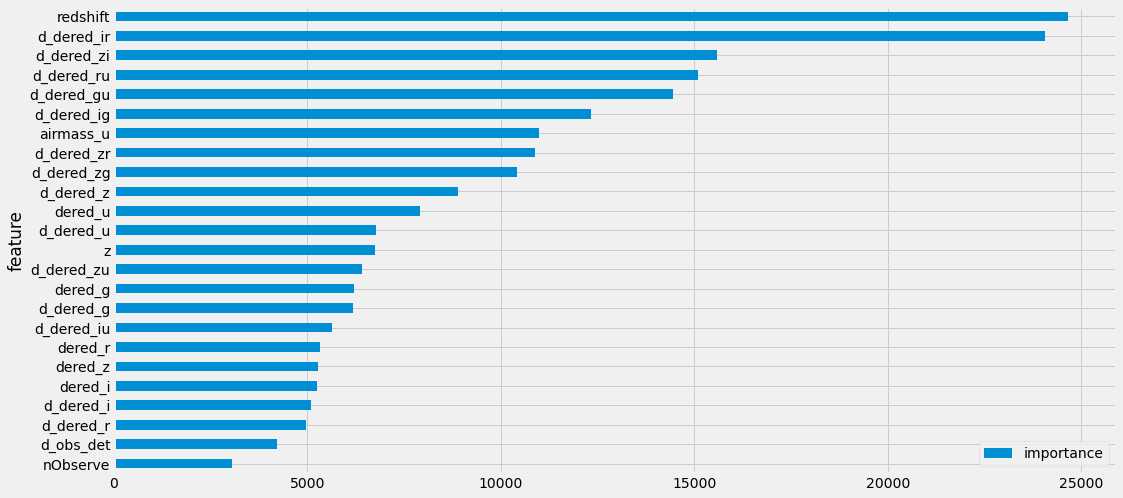

In [14]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [13]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [14]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [15]:
sub[target_col].value_counts()

2    40648
0    29971
1     9381
Name: class, dtype: int64

In [16]:
sub.to_csv(sub_file)

# LGBM 두번째 예측

In [17]:
algo_name = 'lgbcv_last2'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = data_dir / f'{feature_name}.csv'
p_val_file = data_dir / f'{model_name}.val.csv'
p_tst_file = data_dir / f'{model_name}.tst.csv'
sub_file = data_dir / f'{model_name}.csv'

In [18]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             boosting_type='gbdt',
                             n_estimators=5000,
                             max_depth=30,
                             num_leaves=63,
                             learning_rate=0.02,
                             min_child_samples=255,
                             subsample=.6,
                             subsample_freq=1,
                             colsample_bytree=.9,
                             random_state=42,
                             n_jobs=-1)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=100)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.955743
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.927171
[3]	valid_0's multi_logloss: 0.90003
[4]	valid_0's multi_logloss: 0.87601
[5]	valid_0's multi_logloss: 0.85154
[6]	valid_0's multi_logloss: 0.828206
[7]	valid_0's multi_logloss: 0.808346
[8]	valid_0's multi_logloss: 0.786962
[9]	valid_0's multi_logloss: 0.766535
[10]	valid_0's multi_logloss: 0.747018
[11]	valid_0's multi_logloss: 0.72948
[12]	valid_0's multi_logloss: 0.711471
[13]	valid_0's multi_logloss: 0.695335
[14]	valid_0's multi_logloss: 0.678648
[15]	valid_0's multi_logloss: 0.662634
[16]	valid_0's multi_logloss: 0.647276
[17]	valid_0's multi_logloss: 0.632477
[18]	valid_0's multi_logloss: 0.618274
[19]	valid_0's multi_logloss: 0.604718
[20]	valid_0's multi_logloss: 0.591591
[21]	valid_0's multi_logloss: 0.578893
[22]	valid_0's multi_logloss: 0.566713
[23]	valid_0's multi_logloss: 0.554919
[24]	valid_0's multi_logloss:

[207]	valid_0's multi_logloss: 0.165622
[208]	valid_0's multi_logloss: 0.165473
[209]	valid_0's multi_logloss: 0.165324
[210]	valid_0's multi_logloss: 0.165183
[211]	valid_0's multi_logloss: 0.165042
[212]	valid_0's multi_logloss: 0.164924
[213]	valid_0's multi_logloss: 0.164785
[214]	valid_0's multi_logloss: 0.164667
[215]	valid_0's multi_logloss: 0.164552
[216]	valid_0's multi_logloss: 0.164426
[217]	valid_0's multi_logloss: 0.164297
[218]	valid_0's multi_logloss: 0.164187
[219]	valid_0's multi_logloss: 0.164054
[220]	valid_0's multi_logloss: 0.163928
[221]	valid_0's multi_logloss: 0.163823
[222]	valid_0's multi_logloss: 0.163704
[223]	valid_0's multi_logloss: 0.163601
[224]	valid_0's multi_logloss: 0.16348
[225]	valid_0's multi_logloss: 0.163375
[226]	valid_0's multi_logloss: 0.163268
[227]	valid_0's multi_logloss: 0.163161
[228]	valid_0's multi_logloss: 0.163054
[229]	valid_0's multi_logloss: 0.162928
[230]	valid_0's multi_logloss: 0.162809
[231]	valid_0's multi_logloss: 0.162708
[

[416]	valid_0's multi_logloss: 0.15507
[417]	valid_0's multi_logloss: 0.155067
[418]	valid_0's multi_logloss: 0.155062
[419]	valid_0's multi_logloss: 0.155055
[420]	valid_0's multi_logloss: 0.155044
[421]	valid_0's multi_logloss: 0.155026
[422]	valid_0's multi_logloss: 0.155016
[423]	valid_0's multi_logloss: 0.154993
[424]	valid_0's multi_logloss: 0.154983
[425]	valid_0's multi_logloss: 0.15496
[426]	valid_0's multi_logloss: 0.154944
[427]	valid_0's multi_logloss: 0.154942
[428]	valid_0's multi_logloss: 0.154932
[429]	valid_0's multi_logloss: 0.154919
[430]	valid_0's multi_logloss: 0.154912
[431]	valid_0's multi_logloss: 0.154905
[432]	valid_0's multi_logloss: 0.154886
[433]	valid_0's multi_logloss: 0.154879
[434]	valid_0's multi_logloss: 0.154871
[435]	valid_0's multi_logloss: 0.154873
[436]	valid_0's multi_logloss: 0.154863
[437]	valid_0's multi_logloss: 0.154851
[438]	valid_0's multi_logloss: 0.154848
[439]	valid_0's multi_logloss: 0.154836
[440]	valid_0's multi_logloss: 0.154817
[4

[623]	valid_0's multi_logloss: 0.153838
[624]	valid_0's multi_logloss: 0.153831
[625]	valid_0's multi_logloss: 0.153833
[626]	valid_0's multi_logloss: 0.153834
[627]	valid_0's multi_logloss: 0.153831
[628]	valid_0's multi_logloss: 0.153822
[629]	valid_0's multi_logloss: 0.153812
[630]	valid_0's multi_logloss: 0.153813
[631]	valid_0's multi_logloss: 0.153817
[632]	valid_0's multi_logloss: 0.153814
[633]	valid_0's multi_logloss: 0.153816
[634]	valid_0's multi_logloss: 0.153822
[635]	valid_0's multi_logloss: 0.153819
[636]	valid_0's multi_logloss: 0.153821
[637]	valid_0's multi_logloss: 0.153826
[638]	valid_0's multi_logloss: 0.153823
[639]	valid_0's multi_logloss: 0.153824
[640]	valid_0's multi_logloss: 0.153824
[641]	valid_0's multi_logloss: 0.153819
[642]	valid_0's multi_logloss: 0.153818
[643]	valid_0's multi_logloss: 0.153812
[644]	valid_0's multi_logloss: 0.15381
[645]	valid_0's multi_logloss: 0.153813
[646]	valid_0's multi_logloss: 0.153812
[647]	valid_0's multi_logloss: 0.153807
[

[830]	valid_0's multi_logloss: 0.153528
[831]	valid_0's multi_logloss: 0.153525
[832]	valid_0's multi_logloss: 0.153528
[833]	valid_0's multi_logloss: 0.15352
[834]	valid_0's multi_logloss: 0.153521
[835]	valid_0's multi_logloss: 0.153527
[836]	valid_0's multi_logloss: 0.153533
[837]	valid_0's multi_logloss: 0.153535
[838]	valid_0's multi_logloss: 0.15354
[839]	valid_0's multi_logloss: 0.153536
[840]	valid_0's multi_logloss: 0.153544
[841]	valid_0's multi_logloss: 0.153553
[842]	valid_0's multi_logloss: 0.153554
[843]	valid_0's multi_logloss: 0.153556
[844]	valid_0's multi_logloss: 0.153557
[845]	valid_0's multi_logloss: 0.153558
[846]	valid_0's multi_logloss: 0.153553
[847]	valid_0's multi_logloss: 0.153552
[848]	valid_0's multi_logloss: 0.153552
[849]	valid_0's multi_logloss: 0.153547
[850]	valid_0's multi_logloss: 0.153538
[851]	valid_0's multi_logloss: 0.153529
[852]	valid_0's multi_logloss: 0.153522
[853]	valid_0's multi_logloss: 0.153519
[854]	valid_0's multi_logloss: 0.153519
[8

[38]	valid_0's multi_logloss: 0.420843
[39]	valid_0's multi_logloss: 0.413896
[40]	valid_0's multi_logloss: 0.407167
[41]	valid_0's multi_logloss: 0.400699
[42]	valid_0's multi_logloss: 0.394386
[43]	valid_0's multi_logloss: 0.388239
[44]	valid_0's multi_logloss: 0.382355
[45]	valid_0's multi_logloss: 0.376588
[46]	valid_0's multi_logloss: 0.371002
[47]	valid_0's multi_logloss: 0.366003
[48]	valid_0's multi_logloss: 0.360871
[49]	valid_0's multi_logloss: 0.355774
[50]	valid_0's multi_logloss: 0.350792
[51]	valid_0's multi_logloss: 0.345978
[52]	valid_0's multi_logloss: 0.341536
[53]	valid_0's multi_logloss: 0.336986
[54]	valid_0's multi_logloss: 0.332561
[55]	valid_0's multi_logloss: 0.328253
[56]	valid_0's multi_logloss: 0.32431
[57]	valid_0's multi_logloss: 0.320264
[58]	valid_0's multi_logloss: 0.316623
[59]	valid_0's multi_logloss: 0.313183
[60]	valid_0's multi_logloss: 0.309446
[61]	valid_0's multi_logloss: 0.305821
[62]	valid_0's multi_logloss: 0.302289
[63]	valid_0's multi_loglo

[245]	valid_0's multi_logloss: 0.162885
[246]	valid_0's multi_logloss: 0.162789
[247]	valid_0's multi_logloss: 0.162719
[248]	valid_0's multi_logloss: 0.162639
[249]	valid_0's multi_logloss: 0.162546
[250]	valid_0's multi_logloss: 0.162448
[251]	valid_0's multi_logloss: 0.162374
[252]	valid_0's multi_logloss: 0.162297
[253]	valid_0's multi_logloss: 0.162204
[254]	valid_0's multi_logloss: 0.162127
[255]	valid_0's multi_logloss: 0.16206
[256]	valid_0's multi_logloss: 0.162008
[257]	valid_0's multi_logloss: 0.16195
[258]	valid_0's multi_logloss: 0.16188
[259]	valid_0's multi_logloss: 0.161821
[260]	valid_0's multi_logloss: 0.161759
[261]	valid_0's multi_logloss: 0.161693
[262]	valid_0's multi_logloss: 0.161618
[263]	valid_0's multi_logloss: 0.161567
[264]	valid_0's multi_logloss: 0.161509
[265]	valid_0's multi_logloss: 0.16143
[266]	valid_0's multi_logloss: 0.161372
[267]	valid_0's multi_logloss: 0.161316
[268]	valid_0's multi_logloss: 0.161249
[269]	valid_0's multi_logloss: 0.161187
[270

[451]	valid_0's multi_logloss: 0.156545
[452]	valid_0's multi_logloss: 0.15653
[453]	valid_0's multi_logloss: 0.156521
[454]	valid_0's multi_logloss: 0.156505
[455]	valid_0's multi_logloss: 0.156513
[456]	valid_0's multi_logloss: 0.156503
[457]	valid_0's multi_logloss: 0.1565
[458]	valid_0's multi_logloss: 0.156496
[459]	valid_0's multi_logloss: 0.156488
[460]	valid_0's multi_logloss: 0.156479
[461]	valid_0's multi_logloss: 0.156473
[462]	valid_0's multi_logloss: 0.156462
[463]	valid_0's multi_logloss: 0.156464
[464]	valid_0's multi_logloss: 0.156451
[465]	valid_0's multi_logloss: 0.156437
[466]	valid_0's multi_logloss: 0.156432
[467]	valid_0's multi_logloss: 0.156425
[468]	valid_0's multi_logloss: 0.156422
[469]	valid_0's multi_logloss: 0.156412
[470]	valid_0's multi_logloss: 0.156397
[471]	valid_0's multi_logloss: 0.156399
[472]	valid_0's multi_logloss: 0.156379
[473]	valid_0's multi_logloss: 0.156385
[474]	valid_0's multi_logloss: 0.156387
[475]	valid_0's multi_logloss: 0.156385
[47

[657]	valid_0's multi_logloss: 0.155629
[658]	valid_0's multi_logloss: 0.155629
[659]	valid_0's multi_logloss: 0.155626
[660]	valid_0's multi_logloss: 0.155623
[661]	valid_0's multi_logloss: 0.15562
[662]	valid_0's multi_logloss: 0.155621
[663]	valid_0's multi_logloss: 0.155614
[664]	valid_0's multi_logloss: 0.155608
[665]	valid_0's multi_logloss: 0.1556
[666]	valid_0's multi_logloss: 0.155588
[667]	valid_0's multi_logloss: 0.15558
[668]	valid_0's multi_logloss: 0.155568
[669]	valid_0's multi_logloss: 0.155561
[670]	valid_0's multi_logloss: 0.155551
[671]	valid_0's multi_logloss: 0.155532
[672]	valid_0's multi_logloss: 0.155534
[673]	valid_0's multi_logloss: 0.155541
[674]	valid_0's multi_logloss: 0.155534
[675]	valid_0's multi_logloss: 0.15553
[676]	valid_0's multi_logloss: 0.155531
[677]	valid_0's multi_logloss: 0.155537
[678]	valid_0's multi_logloss: 0.155532
[679]	valid_0's multi_logloss: 0.155533
[680]	valid_0's multi_logloss: 0.155529
[681]	valid_0's multi_logloss: 0.155524
[682]

[863]	valid_0's multi_logloss: 0.155231
[864]	valid_0's multi_logloss: 0.155233
[865]	valid_0's multi_logloss: 0.155234
[866]	valid_0's multi_logloss: 0.155238
[867]	valid_0's multi_logloss: 0.155236
[868]	valid_0's multi_logloss: 0.155233
[869]	valid_0's multi_logloss: 0.155229
[870]	valid_0's multi_logloss: 0.155235
[871]	valid_0's multi_logloss: 0.155241
[872]	valid_0's multi_logloss: 0.15525
[873]	valid_0's multi_logloss: 0.155262
[874]	valid_0's multi_logloss: 0.155256
[875]	valid_0's multi_logloss: 0.155251
[876]	valid_0's multi_logloss: 0.155264
[877]	valid_0's multi_logloss: 0.155265
[878]	valid_0's multi_logloss: 0.155266
[879]	valid_0's multi_logloss: 0.155262
[880]	valid_0's multi_logloss: 0.155269
[881]	valid_0's multi_logloss: 0.155271
[882]	valid_0's multi_logloss: 0.155268
[883]	valid_0's multi_logloss: 0.155275
[884]	valid_0's multi_logloss: 0.155275
[885]	valid_0's multi_logloss: 0.155276
[886]	valid_0's multi_logloss: 0.155273
[887]	valid_0's multi_logloss: 0.155263
[

[109]	valid_0's multi_logloss: 0.207382
[110]	valid_0's multi_logloss: 0.206344
[111]	valid_0's multi_logloss: 0.205334
[112]	valid_0's multi_logloss: 0.204322
[113]	valid_0's multi_logloss: 0.203338
[114]	valid_0's multi_logloss: 0.202402
[115]	valid_0's multi_logloss: 0.201477
[116]	valid_0's multi_logloss: 0.200565
[117]	valid_0's multi_logloss: 0.199728
[118]	valid_0's multi_logloss: 0.198903
[119]	valid_0's multi_logloss: 0.198103
[120]	valid_0's multi_logloss: 0.197259
[121]	valid_0's multi_logloss: 0.19643
[122]	valid_0's multi_logloss: 0.195643
[123]	valid_0's multi_logloss: 0.194908
[124]	valid_0's multi_logloss: 0.194117
[125]	valid_0's multi_logloss: 0.193376
[126]	valid_0's multi_logloss: 0.192644
[127]	valid_0's multi_logloss: 0.191917
[128]	valid_0's multi_logloss: 0.19122
[129]	valid_0's multi_logloss: 0.190532
[130]	valid_0's multi_logloss: 0.189922
[131]	valid_0's multi_logloss: 0.189277
[132]	valid_0's multi_logloss: 0.188642
[133]	valid_0's multi_logloss: 0.188061
[1

[315]	valid_0's multi_logloss: 0.156636
[316]	valid_0's multi_logloss: 0.156606
[317]	valid_0's multi_logloss: 0.156573
[318]	valid_0's multi_logloss: 0.156543
[319]	valid_0's multi_logloss: 0.156521
[320]	valid_0's multi_logloss: 0.156479
[321]	valid_0's multi_logloss: 0.156444
[322]	valid_0's multi_logloss: 0.156398
[323]	valid_0's multi_logloss: 0.156364
[324]	valid_0's multi_logloss: 0.156342
[325]	valid_0's multi_logloss: 0.156312
[326]	valid_0's multi_logloss: 0.156282
[327]	valid_0's multi_logloss: 0.156242
[328]	valid_0's multi_logloss: 0.156215
[329]	valid_0's multi_logloss: 0.156193
[330]	valid_0's multi_logloss: 0.156164
[331]	valid_0's multi_logloss: 0.156146
[332]	valid_0's multi_logloss: 0.15611
[333]	valid_0's multi_logloss: 0.156102
[334]	valid_0's multi_logloss: 0.156075
[335]	valid_0's multi_logloss: 0.156047
[336]	valid_0's multi_logloss: 0.156016
[337]	valid_0's multi_logloss: 0.155994
[338]	valid_0's multi_logloss: 0.155971
[339]	valid_0's multi_logloss: 0.155945
[

[523]	valid_0's multi_logloss: 0.153768
[524]	valid_0's multi_logloss: 0.153763
[525]	valid_0's multi_logloss: 0.153758
[526]	valid_0's multi_logloss: 0.153762
[527]	valid_0's multi_logloss: 0.153764
[528]	valid_0's multi_logloss: 0.153756
[529]	valid_0's multi_logloss: 0.153744
[530]	valid_0's multi_logloss: 0.153746
[531]	valid_0's multi_logloss: 0.153738
[532]	valid_0's multi_logloss: 0.153734
[533]	valid_0's multi_logloss: 0.153734
[534]	valid_0's multi_logloss: 0.15373
[535]	valid_0's multi_logloss: 0.153727
[536]	valid_0's multi_logloss: 0.153729
[537]	valid_0's multi_logloss: 0.153728
[538]	valid_0's multi_logloss: 0.15373
[539]	valid_0's multi_logloss: 0.153728
[540]	valid_0's multi_logloss: 0.153715
[541]	valid_0's multi_logloss: 0.153709
[542]	valid_0's multi_logloss: 0.153705
[543]	valid_0's multi_logloss: 0.153702
[544]	valid_0's multi_logloss: 0.153701
[545]	valid_0's multi_logloss: 0.153695
[546]	valid_0's multi_logloss: 0.153684
[547]	valid_0's multi_logloss: 0.153683
[5

[731]	valid_0's multi_logloss: 0.153389
[732]	valid_0's multi_logloss: 0.153385
[733]	valid_0's multi_logloss: 0.153379
[734]	valid_0's multi_logloss: 0.15337
[735]	valid_0's multi_logloss: 0.153366
[736]	valid_0's multi_logloss: 0.153368
[737]	valid_0's multi_logloss: 0.153371
[738]	valid_0's multi_logloss: 0.153371
[739]	valid_0's multi_logloss: 0.153366
[740]	valid_0's multi_logloss: 0.153364
[741]	valid_0's multi_logloss: 0.153357
[742]	valid_0's multi_logloss: 0.153353
[743]	valid_0's multi_logloss: 0.15335
[744]	valid_0's multi_logloss: 0.15335
[745]	valid_0's multi_logloss: 0.153349
[746]	valid_0's multi_logloss: 0.153352
[747]	valid_0's multi_logloss: 0.153356
[748]	valid_0's multi_logloss: 0.153353
[749]	valid_0's multi_logloss: 0.153343
[750]	valid_0's multi_logloss: 0.153334
[751]	valid_0's multi_logloss: 0.153338
[752]	valid_0's multi_logloss: 0.15333
[753]	valid_0's multi_logloss: 0.153333
[754]	valid_0's multi_logloss: 0.153339
[755]	valid_0's multi_logloss: 0.153335
[756

[939]	valid_0's multi_logloss: 0.153256
[940]	valid_0's multi_logloss: 0.153257
[941]	valid_0's multi_logloss: 0.153257
[942]	valid_0's multi_logloss: 0.153267
[943]	valid_0's multi_logloss: 0.153264
[944]	valid_0's multi_logloss: 0.15326
[945]	valid_0's multi_logloss: 0.153257
[946]	valid_0's multi_logloss: 0.153254
[947]	valid_0's multi_logloss: 0.153253
[948]	valid_0's multi_logloss: 0.153242
[949]	valid_0's multi_logloss: 0.15324
[950]	valid_0's multi_logloss: 0.153235
[951]	valid_0's multi_logloss: 0.153239
[952]	valid_0's multi_logloss: 0.153244
[953]	valid_0's multi_logloss: 0.153241
[954]	valid_0's multi_logloss: 0.153238
[955]	valid_0's multi_logloss: 0.153229
[956]	valid_0's multi_logloss: 0.153241
[957]	valid_0's multi_logloss: 0.153237
[958]	valid_0's multi_logloss: 0.153236
[959]	valid_0's multi_logloss: 0.153223
[960]	valid_0's multi_logloss: 0.153223
[961]	valid_0's multi_logloss: 0.15322
[962]	valid_0's multi_logloss: 0.153222
[963]	valid_0's multi_logloss: 0.153225
[96

[69]	valid_0's multi_logloss: 0.284253
[70]	valid_0's multi_logloss: 0.281429
[71]	valid_0's multi_logloss: 0.278677
[72]	valid_0's multi_logloss: 0.276094
[73]	valid_0's multi_logloss: 0.273484
[74]	valid_0's multi_logloss: 0.270962
[75]	valid_0's multi_logloss: 0.268692
[76]	valid_0's multi_logloss: 0.26627
[77]	valid_0's multi_logloss: 0.263904
[78]	valid_0's multi_logloss: 0.26161
[79]	valid_0's multi_logloss: 0.25938
[80]	valid_0's multi_logloss: 0.257201
[81]	valid_0's multi_logloss: 0.25507
[82]	valid_0's multi_logloss: 0.253231
[83]	valid_0's multi_logloss: 0.251324
[84]	valid_0's multi_logloss: 0.249325
[85]	valid_0's multi_logloss: 0.247491
[86]	valid_0's multi_logloss: 0.24584
[87]	valid_0's multi_logloss: 0.244001
[88]	valid_0's multi_logloss: 0.24219
[89]	valid_0's multi_logloss: 0.240437
[90]	valid_0's multi_logloss: 0.238726
[91]	valid_0's multi_logloss: 0.237076
[92]	valid_0's multi_logloss: 0.235467
[93]	valid_0's multi_logloss: 0.233906
[94]	valid_0's multi_logloss: 0

[276]	valid_0's multi_logloss: 0.16387
[277]	valid_0's multi_logloss: 0.16382
[278]	valid_0's multi_logloss: 0.163771
[279]	valid_0's multi_logloss: 0.163716
[280]	valid_0's multi_logloss: 0.163656
[281]	valid_0's multi_logloss: 0.163612
[282]	valid_0's multi_logloss: 0.163549
[283]	valid_0's multi_logloss: 0.163489
[284]	valid_0's multi_logloss: 0.163449
[285]	valid_0's multi_logloss: 0.163395
[286]	valid_0's multi_logloss: 0.163345
[287]	valid_0's multi_logloss: 0.163308
[288]	valid_0's multi_logloss: 0.163251
[289]	valid_0's multi_logloss: 0.163212
[290]	valid_0's multi_logloss: 0.16317
[291]	valid_0's multi_logloss: 0.163105
[292]	valid_0's multi_logloss: 0.163074
[293]	valid_0's multi_logloss: 0.163031
[294]	valid_0's multi_logloss: 0.162998
[295]	valid_0's multi_logloss: 0.16294
[296]	valid_0's multi_logloss: 0.162904
[297]	valid_0's multi_logloss: 0.162861
[298]	valid_0's multi_logloss: 0.162813
[299]	valid_0's multi_logloss: 0.162769
[300]	valid_0's multi_logloss: 0.162744
[301

[483]	valid_0's multi_logloss: 0.158996
[484]	valid_0's multi_logloss: 0.15898
[485]	valid_0's multi_logloss: 0.15897
[486]	valid_0's multi_logloss: 0.15897
[487]	valid_0's multi_logloss: 0.158957
[488]	valid_0's multi_logloss: 0.158956
[489]	valid_0's multi_logloss: 0.158939
[490]	valid_0's multi_logloss: 0.158935
[491]	valid_0's multi_logloss: 0.158922
[492]	valid_0's multi_logloss: 0.158913
[493]	valid_0's multi_logloss: 0.158909
[494]	valid_0's multi_logloss: 0.158898
[495]	valid_0's multi_logloss: 0.158893
[496]	valid_0's multi_logloss: 0.158894
[497]	valid_0's multi_logloss: 0.158898
[498]	valid_0's multi_logloss: 0.158892
[499]	valid_0's multi_logloss: 0.158877
[500]	valid_0's multi_logloss: 0.158856
[501]	valid_0's multi_logloss: 0.15885
[502]	valid_0's multi_logloss: 0.158842
[503]	valid_0's multi_logloss: 0.158838
[504]	valid_0's multi_logloss: 0.158824
[505]	valid_0's multi_logloss: 0.158821
[506]	valid_0's multi_logloss: 0.15881
[507]	valid_0's multi_logloss: 0.158791
[508]

[895]	valid_0's multi_logloss: 0.157712
[896]	valid_0's multi_logloss: 0.157717
[897]	valid_0's multi_logloss: 0.157713
[898]	valid_0's multi_logloss: 0.157724
[899]	valid_0's multi_logloss: 0.157731
[900]	valid_0's multi_logloss: 0.157736
[901]	valid_0's multi_logloss: 0.157739
[902]	valid_0's multi_logloss: 0.157733
[903]	valid_0's multi_logloss: 0.157732
[904]	valid_0's multi_logloss: 0.157721
[905]	valid_0's multi_logloss: 0.157717
[906]	valid_0's multi_logloss: 0.157719
[907]	valid_0's multi_logloss: 0.157708
[908]	valid_0's multi_logloss: 0.157706
[909]	valid_0's multi_logloss: 0.15771
[910]	valid_0's multi_logloss: 0.157715
[911]	valid_0's multi_logloss: 0.157723
[912]	valid_0's multi_logloss: 0.157714
[913]	valid_0's multi_logloss: 0.157706
[914]	valid_0's multi_logloss: 0.157704
[915]	valid_0's multi_logloss: 0.157702
[916]	valid_0's multi_logloss: 0.157707
[917]	valid_0's multi_logloss: 0.157713
[918]	valid_0's multi_logloss: 0.15772
[919]	valid_0's multi_logloss: 0.157722
[9

[63]	valid_0's multi_logloss: 0.297889
[64]	valid_0's multi_logloss: 0.294577
[65]	valid_0's multi_logloss: 0.291602
[66]	valid_0's multi_logloss: 0.288669
[67]	valid_0's multi_logloss: 0.285552
[68]	valid_0's multi_logloss: 0.282528
[69]	valid_0's multi_logloss: 0.279562
[70]	valid_0's multi_logloss: 0.276673
[71]	valid_0's multi_logloss: 0.273893
[72]	valid_0's multi_logloss: 0.27132
[73]	valid_0's multi_logloss: 0.268661
[74]	valid_0's multi_logloss: 0.266136
[75]	valid_0's multi_logloss: 0.263853
[76]	valid_0's multi_logloss: 0.261403
[77]	valid_0's multi_logloss: 0.259028
[78]	valid_0's multi_logloss: 0.256709
[79]	valid_0's multi_logloss: 0.254456
[80]	valid_0's multi_logloss: 0.252268
[81]	valid_0's multi_logloss: 0.250138
[82]	valid_0's multi_logloss: 0.248315
[83]	valid_0's multi_logloss: 0.246413
[84]	valid_0's multi_logloss: 0.244414
[85]	valid_0's multi_logloss: 0.242531
[86]	valid_0's multi_logloss: 0.240843
[87]	valid_0's multi_logloss: 0.238984
[88]	valid_0's multi_loglo

[272]	valid_0's multi_logloss: 0.15927
[273]	valid_0's multi_logloss: 0.159224
[274]	valid_0's multi_logloss: 0.159168
[275]	valid_0's multi_logloss: 0.159126
[276]	valid_0's multi_logloss: 0.159075
[277]	valid_0's multi_logloss: 0.159038
[278]	valid_0's multi_logloss: 0.158993
[279]	valid_0's multi_logloss: 0.158949
[280]	valid_0's multi_logloss: 0.158882
[281]	valid_0's multi_logloss: 0.158826
[282]	valid_0's multi_logloss: 0.158782
[283]	valid_0's multi_logloss: 0.158721
[284]	valid_0's multi_logloss: 0.15868
[285]	valid_0's multi_logloss: 0.158622
[286]	valid_0's multi_logloss: 0.158573
[287]	valid_0's multi_logloss: 0.15853
[288]	valid_0's multi_logloss: 0.158473
[289]	valid_0's multi_logloss: 0.158418
[290]	valid_0's multi_logloss: 0.158368
[291]	valid_0's multi_logloss: 0.158322
[292]	valid_0's multi_logloss: 0.158277
[293]	valid_0's multi_logloss: 0.158244
[294]	valid_0's multi_logloss: 0.158213
[295]	valid_0's multi_logloss: 0.158168
[296]	valid_0's multi_logloss: 0.158125
[29

[478]	valid_0's multi_logloss: 0.155014
[479]	valid_0's multi_logloss: 0.154997
[480]	valid_0's multi_logloss: 0.154997
[481]	valid_0's multi_logloss: 0.154993
[482]	valid_0's multi_logloss: 0.154973
[483]	valid_0's multi_logloss: 0.154963
[484]	valid_0's multi_logloss: 0.154973
[485]	valid_0's multi_logloss: 0.154971
[486]	valid_0's multi_logloss: 0.15496
[487]	valid_0's multi_logloss: 0.154955
[488]	valid_0's multi_logloss: 0.154949
[489]	valid_0's multi_logloss: 0.154943
[490]	valid_0's multi_logloss: 0.15493
[491]	valid_0's multi_logloss: 0.154917
[492]	valid_0's multi_logloss: 0.154905
[493]	valid_0's multi_logloss: 0.154907
[494]	valid_0's multi_logloss: 0.154901
[495]	valid_0's multi_logloss: 0.154908
[496]	valid_0's multi_logloss: 0.154905
[497]	valid_0's multi_logloss: 0.154907
[498]	valid_0's multi_logloss: 0.154896
[499]	valid_0's multi_logloss: 0.154897
[500]	valid_0's multi_logloss: 0.154902
[501]	valid_0's multi_logloss: 0.154896
[502]	valid_0's multi_logloss: 0.154891
[5

[684]	valid_0's multi_logloss: 0.154294
[685]	valid_0's multi_logloss: 0.154291
[686]	valid_0's multi_logloss: 0.154299
[687]	valid_0's multi_logloss: 0.154291
[688]	valid_0's multi_logloss: 0.154291
[689]	valid_0's multi_logloss: 0.154292
[690]	valid_0's multi_logloss: 0.154291
[691]	valid_0's multi_logloss: 0.154289
[692]	valid_0's multi_logloss: 0.154281
[693]	valid_0's multi_logloss: 0.154284
[694]	valid_0's multi_logloss: 0.154275
[695]	valid_0's multi_logloss: 0.154273
[696]	valid_0's multi_logloss: 0.154273
[697]	valid_0's multi_logloss: 0.154266
[698]	valid_0's multi_logloss: 0.154268
[699]	valid_0's multi_logloss: 0.154273
[700]	valid_0's multi_logloss: 0.154262
[701]	valid_0's multi_logloss: 0.154262
[702]	valid_0's multi_logloss: 0.154262
[703]	valid_0's multi_logloss: 0.154269
[704]	valid_0's multi_logloss: 0.154267
[705]	valid_0's multi_logloss: 0.154256
[706]	valid_0's multi_logloss: 0.154248
[707]	valid_0's multi_logloss: 0.154252
[708]	valid_0's multi_logloss: 0.15426
[

[58]	valid_0's multi_logloss: 0.319031
[59]	valid_0's multi_logloss: 0.315598
[60]	valid_0's multi_logloss: 0.311851
[61]	valid_0's multi_logloss: 0.308221
[62]	valid_0's multi_logloss: 0.304698
[63]	valid_0's multi_logloss: 0.301273
[64]	valid_0's multi_logloss: 0.297986
[65]	valid_0's multi_logloss: 0.295012
[66]	valid_0's multi_logloss: 0.292122
[67]	valid_0's multi_logloss: 0.289029
[68]	valid_0's multi_logloss: 0.286056
[69]	valid_0's multi_logloss: 0.283125
[70]	valid_0's multi_logloss: 0.280314
[71]	valid_0's multi_logloss: 0.277576
[72]	valid_0's multi_logloss: 0.275017
[73]	valid_0's multi_logloss: 0.272375
[74]	valid_0's multi_logloss: 0.26986
[75]	valid_0's multi_logloss: 0.267575
[76]	valid_0's multi_logloss: 0.265137
[77]	valid_0's multi_logloss: 0.262749
[78]	valid_0's multi_logloss: 0.260461
[79]	valid_0's multi_logloss: 0.258191
[80]	valid_0's multi_logloss: 0.256034
[81]	valid_0's multi_logloss: 0.253916
[82]	valid_0's multi_logloss: 0.252129
[83]	valid_0's multi_loglo

[469]	valid_0's multi_logloss: 0.159448
[470]	valid_0's multi_logloss: 0.159431
[471]	valid_0's multi_logloss: 0.159432
[472]	valid_0's multi_logloss: 0.159432
[473]	valid_0's multi_logloss: 0.159426
[474]	valid_0's multi_logloss: 0.159408
[475]	valid_0's multi_logloss: 0.159407
[476]	valid_0's multi_logloss: 0.159397
[477]	valid_0's multi_logloss: 0.159386
[478]	valid_0's multi_logloss: 0.159379
[479]	valid_0's multi_logloss: 0.159383
[480]	valid_0's multi_logloss: 0.159382
[481]	valid_0's multi_logloss: 0.159373
[482]	valid_0's multi_logloss: 0.159368
[483]	valid_0's multi_logloss: 0.15936
[484]	valid_0's multi_logloss: 0.159349
[485]	valid_0's multi_logloss: 0.159347
[486]	valid_0's multi_logloss: 0.159327
[487]	valid_0's multi_logloss: 0.159327
[488]	valid_0's multi_logloss: 0.159328
[489]	valid_0's multi_logloss: 0.159319
[490]	valid_0's multi_logloss: 0.15931
[491]	valid_0's multi_logloss: 0.15931
[492]	valid_0's multi_logloss: 0.159316
[493]	valid_0's multi_logloss: 0.159311
[49

[675]	valid_0's multi_logloss: 0.15875
[676]	valid_0's multi_logloss: 0.15876
[677]	valid_0's multi_logloss: 0.158753
[678]	valid_0's multi_logloss: 0.158745
[679]	valid_0's multi_logloss: 0.158741
[680]	valid_0's multi_logloss: 0.158739
[681]	valid_0's multi_logloss: 0.158741
[682]	valid_0's multi_logloss: 0.158748
[683]	valid_0's multi_logloss: 0.158751
[684]	valid_0's multi_logloss: 0.158758
[685]	valid_0's multi_logloss: 0.158752
[686]	valid_0's multi_logloss: 0.158759
[687]	valid_0's multi_logloss: 0.158748
[688]	valid_0's multi_logloss: 0.158744
[689]	valid_0's multi_logloss: 0.158737
[690]	valid_0's multi_logloss: 0.158735
[691]	valid_0's multi_logloss: 0.158723
[692]	valid_0's multi_logloss: 0.158721
[693]	valid_0's multi_logloss: 0.158732
[694]	valid_0's multi_logloss: 0.158729
[695]	valid_0's multi_logloss: 0.158728
[696]	valid_0's multi_logloss: 0.158719
[697]	valid_0's multi_logloss: 0.158716
[698]	valid_0's multi_logloss: 0.158714
[699]	valid_0's multi_logloss: 0.158716
[7

[7]	valid_0's multi_logloss: 0.80843
[8]	valid_0's multi_logloss: 0.787051
[9]	valid_0's multi_logloss: 0.766601
[10]	valid_0's multi_logloss: 0.747112
[11]	valid_0's multi_logloss: 0.729645
[12]	valid_0's multi_logloss: 0.711625
[13]	valid_0's multi_logloss: 0.695474
[14]	valid_0's multi_logloss: 0.678851
[15]	valid_0's multi_logloss: 0.662888
[16]	valid_0's multi_logloss: 0.647506
[17]	valid_0's multi_logloss: 0.632708
[18]	valid_0's multi_logloss: 0.618484
[19]	valid_0's multi_logloss: 0.604882
[20]	valid_0's multi_logloss: 0.591797
[21]	valid_0's multi_logloss: 0.579091
[22]	valid_0's multi_logloss: 0.566934
[23]	valid_0's multi_logloss: 0.555141
[24]	valid_0's multi_logloss: 0.543919
[25]	valid_0's multi_logloss: 0.53291
[26]	valid_0's multi_logloss: 0.522254
[27]	valid_0's multi_logloss: 0.511955
[28]	valid_0's multi_logloss: 0.502055
[29]	valid_0's multi_logloss: 0.492438
[30]	valid_0's multi_logloss: 0.483189
[31]	valid_0's multi_logloss: 0.474213
[32]	valid_0's multi_logloss: 

[216]	valid_0's multi_logloss: 0.164218
[217]	valid_0's multi_logloss: 0.164098
[218]	valid_0's multi_logloss: 0.163977
[219]	valid_0's multi_logloss: 0.163862
[220]	valid_0's multi_logloss: 0.163744
[221]	valid_0's multi_logloss: 0.163659
[222]	valid_0's multi_logloss: 0.163542
[223]	valid_0's multi_logloss: 0.16344
[224]	valid_0's multi_logloss: 0.163331
[225]	valid_0's multi_logloss: 0.163212
[226]	valid_0's multi_logloss: 0.163111
[227]	valid_0's multi_logloss: 0.163006
[228]	valid_0's multi_logloss: 0.162899
[229]	valid_0's multi_logloss: 0.162776
[230]	valid_0's multi_logloss: 0.162664
[231]	valid_0's multi_logloss: 0.162584
[232]	valid_0's multi_logloss: 0.162473
[233]	valid_0's multi_logloss: 0.162368
[234]	valid_0's multi_logloss: 0.162282
[235]	valid_0's multi_logloss: 0.16218
[236]	valid_0's multi_logloss: 0.16208
[237]	valid_0's multi_logloss: 0.161977
[238]	valid_0's multi_logloss: 0.161888
[239]	valid_0's multi_logloss: 0.161802
[240]	valid_0's multi_logloss: 0.16172
[241

[425]	valid_0's multi_logloss: 0.155058
[426]	valid_0's multi_logloss: 0.155043
[427]	valid_0's multi_logloss: 0.15503
[428]	valid_0's multi_logloss: 0.155013
[429]	valid_0's multi_logloss: 0.155008
[430]	valid_0's multi_logloss: 0.154988
[431]	valid_0's multi_logloss: 0.154975
[432]	valid_0's multi_logloss: 0.15497
[433]	valid_0's multi_logloss: 0.154955
[434]	valid_0's multi_logloss: 0.154958
[435]	valid_0's multi_logloss: 0.154955
[436]	valid_0's multi_logloss: 0.154943
[437]	valid_0's multi_logloss: 0.154934
[438]	valid_0's multi_logloss: 0.154915
[439]	valid_0's multi_logloss: 0.154897
[440]	valid_0's multi_logloss: 0.154888
[441]	valid_0's multi_logloss: 0.154875
[442]	valid_0's multi_logloss: 0.154854
[443]	valid_0's multi_logloss: 0.154846
[444]	valid_0's multi_logloss: 0.154847
[445]	valid_0's multi_logloss: 0.154821
[446]	valid_0's multi_logloss: 0.154809
[447]	valid_0's multi_logloss: 0.154803
[448]	valid_0's multi_logloss: 0.154779
[449]	valid_0's multi_logloss: 0.154763
[4

[631]	valid_0's multi_logloss: 0.153435
[632]	valid_0's multi_logloss: 0.153434
[633]	valid_0's multi_logloss: 0.153433
[634]	valid_0's multi_logloss: 0.153429
[635]	valid_0's multi_logloss: 0.153438
[636]	valid_0's multi_logloss: 0.153432
[637]	valid_0's multi_logloss: 0.153427
[638]	valid_0's multi_logloss: 0.153416
[639]	valid_0's multi_logloss: 0.153414
[640]	valid_0's multi_logloss: 0.153406
[641]	valid_0's multi_logloss: 0.153403
[642]	valid_0's multi_logloss: 0.153396
[643]	valid_0's multi_logloss: 0.153386
[644]	valid_0's multi_logloss: 0.153391
[645]	valid_0's multi_logloss: 0.153396
[646]	valid_0's multi_logloss: 0.153389
[647]	valid_0's multi_logloss: 0.153402
[648]	valid_0's multi_logloss: 0.153395
[649]	valid_0's multi_logloss: 0.153388
[650]	valid_0's multi_logloss: 0.153389
[651]	valid_0's multi_logloss: 0.15338
[652]	valid_0's multi_logloss: 0.153371
[653]	valid_0's multi_logloss: 0.153365
[654]	valid_0's multi_logloss: 0.153362
[655]	valid_0's multi_logloss: 0.153366
[

[837]	valid_0's multi_logloss: 0.153067
[838]	valid_0's multi_logloss: 0.15306
[839]	valid_0's multi_logloss: 0.153064
[840]	valid_0's multi_logloss: 0.153066
[841]	valid_0's multi_logloss: 0.153062
[842]	valid_0's multi_logloss: 0.153071
[843]	valid_0's multi_logloss: 0.153067
[844]	valid_0's multi_logloss: 0.153063
[845]	valid_0's multi_logloss: 0.153063
[846]	valid_0's multi_logloss: 0.153064
[847]	valid_0's multi_logloss: 0.153067
[848]	valid_0's multi_logloss: 0.153061
[849]	valid_0's multi_logloss: 0.153053
[850]	valid_0's multi_logloss: 0.153057
[851]	valid_0's multi_logloss: 0.153056
[852]	valid_0's multi_logloss: 0.153048
[853]	valid_0's multi_logloss: 0.153038
[854]	valid_0's multi_logloss: 0.153028
[855]	valid_0's multi_logloss: 0.15303
[856]	valid_0's multi_logloss: 0.153025
[857]	valid_0's multi_logloss: 0.153022
[858]	valid_0's multi_logloss: 0.153019
[859]	valid_0's multi_logloss: 0.153017
[860]	valid_0's multi_logloss: 0.153014
[861]	valid_0's multi_logloss: 0.153013
[8

[1042]	valid_0's multi_logloss: 0.1529
[1043]	valid_0's multi_logloss: 0.152903
[1044]	valid_0's multi_logloss: 0.152902
[1045]	valid_0's multi_logloss: 0.152889
[1046]	valid_0's multi_logloss: 0.152899
[1047]	valid_0's multi_logloss: 0.152905
[1048]	valid_0's multi_logloss: 0.152914
[1049]	valid_0's multi_logloss: 0.15292
[1050]	valid_0's multi_logloss: 0.152914
[1051]	valid_0's multi_logloss: 0.152919
[1052]	valid_0's multi_logloss: 0.15292
[1053]	valid_0's multi_logloss: 0.152921
[1054]	valid_0's multi_logloss: 0.152921
[1055]	valid_0's multi_logloss: 0.152916
[1056]	valid_0's multi_logloss: 0.152922
[1057]	valid_0's multi_logloss: 0.152917
[1058]	valid_0's multi_logloss: 0.152928
[1059]	valid_0's multi_logloss: 0.152922
[1060]	valid_0's multi_logloss: 0.152929
[1061]	valid_0's multi_logloss: 0.15293
[1062]	valid_0's multi_logloss: 0.152935
[1063]	valid_0's multi_logloss: 0.152934
[1064]	valid_0's multi_logloss: 0.152932
[1065]	valid_0's multi_logloss: 0.152949
[1066]	valid_0's mult

[156]	valid_0's multi_logloss: 0.181747
[157]	valid_0's multi_logloss: 0.18138
[158]	valid_0's multi_logloss: 0.181015
[159]	valid_0's multi_logloss: 0.180656
[160]	valid_0's multi_logloss: 0.180286
[161]	valid_0's multi_logloss: 0.179955
[162]	valid_0's multi_logloss: 0.179641
[163]	valid_0's multi_logloss: 0.179288
[164]	valid_0's multi_logloss: 0.178944
[165]	valid_0's multi_logloss: 0.178658
[166]	valid_0's multi_logloss: 0.178343
[167]	valid_0's multi_logloss: 0.178047
[168]	valid_0's multi_logloss: 0.177738
[169]	valid_0's multi_logloss: 0.177431
[170]	valid_0's multi_logloss: 0.177139
[171]	valid_0's multi_logloss: 0.176869
[172]	valid_0's multi_logloss: 0.176608
[173]	valid_0's multi_logloss: 0.176318
[174]	valid_0's multi_logloss: 0.176042
[175]	valid_0's multi_logloss: 0.175774
[176]	valid_0's multi_logloss: 0.175498
[177]	valid_0's multi_logloss: 0.175233
[178]	valid_0's multi_logloss: 0.174967
[179]	valid_0's multi_logloss: 0.174718
[180]	valid_0's multi_logloss: 0.174463
[

[364]	valid_0's multi_logloss: 0.159349
[365]	valid_0's multi_logloss: 0.159339
[366]	valid_0's multi_logloss: 0.159311
[367]	valid_0's multi_logloss: 0.159287
[368]	valid_0's multi_logloss: 0.15927
[369]	valid_0's multi_logloss: 0.159243
[370]	valid_0's multi_logloss: 0.159224
[371]	valid_0's multi_logloss: 0.159204
[372]	valid_0's multi_logloss: 0.159176
[373]	valid_0's multi_logloss: 0.159171
[374]	valid_0's multi_logloss: 0.159157
[375]	valid_0's multi_logloss: 0.159141
[376]	valid_0's multi_logloss: 0.159131
[377]	valid_0's multi_logloss: 0.159102
[378]	valid_0's multi_logloss: 0.159085
[379]	valid_0's multi_logloss: 0.159076
[380]	valid_0's multi_logloss: 0.15905
[381]	valid_0's multi_logloss: 0.159034
[382]	valid_0's multi_logloss: 0.159013
[383]	valid_0's multi_logloss: 0.159006
[384]	valid_0's multi_logloss: 0.158994
[385]	valid_0's multi_logloss: 0.158969
[386]	valid_0's multi_logloss: 0.158949
[387]	valid_0's multi_logloss: 0.158925
[388]	valid_0's multi_logloss: 0.158914
[3

[776]	valid_0's multi_logloss: 0.156607
[777]	valid_0's multi_logloss: 0.156603
[778]	valid_0's multi_logloss: 0.156603
[779]	valid_0's multi_logloss: 0.156607
[780]	valid_0's multi_logloss: 0.156603
[781]	valid_0's multi_logloss: 0.156602
[782]	valid_0's multi_logloss: 0.156603
[783]	valid_0's multi_logloss: 0.156593
[784]	valid_0's multi_logloss: 0.156599
[785]	valid_0's multi_logloss: 0.156599
[786]	valid_0's multi_logloss: 0.156594
[787]	valid_0's multi_logloss: 0.156599
[788]	valid_0's multi_logloss: 0.156599
[789]	valid_0's multi_logloss: 0.156593
[790]	valid_0's multi_logloss: 0.156593
[791]	valid_0's multi_logloss: 0.156585
[792]	valid_0's multi_logloss: 0.156591
[793]	valid_0's multi_logloss: 0.156594
[794]	valid_0's multi_logloss: 0.156595
[795]	valid_0's multi_logloss: 0.156604
[796]	valid_0's multi_logloss: 0.1566
[797]	valid_0's multi_logloss: 0.156599
[798]	valid_0's multi_logloss: 0.156601
[799]	valid_0's multi_logloss: 0.156603
[800]	valid_0's multi_logloss: 0.156605
[8

[985]	valid_0's multi_logloss: 0.156515
[986]	valid_0's multi_logloss: 0.156521
[987]	valid_0's multi_logloss: 0.156528
[988]	valid_0's multi_logloss: 0.156523
[989]	valid_0's multi_logloss: 0.156515
[990]	valid_0's multi_logloss: 0.156517
[991]	valid_0's multi_logloss: 0.156522
[992]	valid_0's multi_logloss: 0.156524
[993]	valid_0's multi_logloss: 0.15652
[994]	valid_0's multi_logloss: 0.156515
[995]	valid_0's multi_logloss: 0.156515
[996]	valid_0's multi_logloss: 0.15652
[997]	valid_0's multi_logloss: 0.156521
[998]	valid_0's multi_logloss: 0.156514
[999]	valid_0's multi_logloss: 0.156514
[1000]	valid_0's multi_logloss: 0.156506
[1001]	valid_0's multi_logloss: 0.156504
[1002]	valid_0's multi_logloss: 0.156504
[1003]	valid_0's multi_logloss: 0.1565
[1004]	valid_0's multi_logloss: 0.156497
[1005]	valid_0's multi_logloss: 0.156497
[1006]	valid_0's multi_logloss: 0.156496
[1007]	valid_0's multi_logloss: 0.156497
[1008]	valid_0's multi_logloss: 0.156492
[1009]	valid_0's multi_logloss: 0.1

training model for CV #9
[1]	valid_0's multi_logloss: 0.955712
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.927113
[3]	valid_0's multi_logloss: 0.900002
[4]	valid_0's multi_logloss: 0.87592
[5]	valid_0's multi_logloss: 0.851384
[6]	valid_0's multi_logloss: 0.827952
[7]	valid_0's multi_logloss: 0.808152
[8]	valid_0's multi_logloss: 0.786728
[9]	valid_0's multi_logloss: 0.766341
[10]	valid_0's multi_logloss: 0.746797
[11]	valid_0's multi_logloss: 0.729299
[12]	valid_0's multi_logloss: 0.711223
[13]	valid_0's multi_logloss: 0.695015
[14]	valid_0's multi_logloss: 0.678363
[15]	valid_0's multi_logloss: 0.662342
[16]	valid_0's multi_logloss: 0.646938
[17]	valid_0's multi_logloss: 0.63211
[18]	valid_0's multi_logloss: 0.617856
[19]	valid_0's multi_logloss: 0.60423
[20]	valid_0's multi_logloss: 0.591166
[21]	valid_0's multi_logloss: 0.578446
[22]	valid_0's multi_logloss: 0.566223
[23]	valid_0's multi_logloss: 0.554408
[24]	valid_0's multi_logloss

[208]	valid_0's multi_logloss: 0.163204
[209]	valid_0's multi_logloss: 0.163052
[210]	valid_0's multi_logloss: 0.162914
[211]	valid_0's multi_logloss: 0.162785
[212]	valid_0's multi_logloss: 0.162655
[213]	valid_0's multi_logloss: 0.162527
[214]	valid_0's multi_logloss: 0.162405
[215]	valid_0's multi_logloss: 0.162298
[216]	valid_0's multi_logloss: 0.162173
[217]	valid_0's multi_logloss: 0.162051
[218]	valid_0's multi_logloss: 0.16194
[219]	valid_0's multi_logloss: 0.16182
[220]	valid_0's multi_logloss: 0.161685
[221]	valid_0's multi_logloss: 0.161592
[222]	valid_0's multi_logloss: 0.161475
[223]	valid_0's multi_logloss: 0.161362
[224]	valid_0's multi_logloss: 0.161249
[225]	valid_0's multi_logloss: 0.161133
[226]	valid_0's multi_logloss: 0.161001
[227]	valid_0's multi_logloss: 0.16089
[228]	valid_0's multi_logloss: 0.16079
[229]	valid_0's multi_logloss: 0.160665
[230]	valid_0's multi_logloss: 0.160567
[231]	valid_0's multi_logloss: 0.160468
[232]	valid_0's multi_logloss: 0.160357
[233

[620]	valid_0's multi_logloss: 0.151745
[621]	valid_0's multi_logloss: 0.151742
[622]	valid_0's multi_logloss: 0.15173
[623]	valid_0's multi_logloss: 0.151723
[624]	valid_0's multi_logloss: 0.1517
[625]	valid_0's multi_logloss: 0.151708
[626]	valid_0's multi_logloss: 0.151709
[627]	valid_0's multi_logloss: 0.151714
[628]	valid_0's multi_logloss: 0.151708
[629]	valid_0's multi_logloss: 0.151712
[630]	valid_0's multi_logloss: 0.151699
[631]	valid_0's multi_logloss: 0.151703
[632]	valid_0's multi_logloss: 0.151702
[633]	valid_0's multi_logloss: 0.1517
[634]	valid_0's multi_logloss: 0.151697
[635]	valid_0's multi_logloss: 0.151685
[636]	valid_0's multi_logloss: 0.151687
[637]	valid_0's multi_logloss: 0.151685
[638]	valid_0's multi_logloss: 0.151678
[639]	valid_0's multi_logloss: 0.15167
[640]	valid_0's multi_logloss: 0.151665
[641]	valid_0's multi_logloss: 0.151659
[642]	valid_0's multi_logloss: 0.151662
[643]	valid_0's multi_logloss: 0.151653
[644]	valid_0's multi_logloss: 0.151645
[645]	

[28]	valid_0's multi_logloss: 0.504023
[29]	valid_0's multi_logloss: 0.494451
[30]	valid_0's multi_logloss: 0.485191
[31]	valid_0's multi_logloss: 0.476244
[32]	valid_0's multi_logloss: 0.46758
[33]	valid_0's multi_logloss: 0.459262
[34]	valid_0's multi_logloss: 0.451628
[35]	valid_0's multi_logloss: 0.443781
[36]	valid_0's multi_logloss: 0.436241
[37]	valid_0's multi_logloss: 0.428887
[38]	valid_0's multi_logloss: 0.421765
[39]	valid_0's multi_logloss: 0.414856
[40]	valid_0's multi_logloss: 0.40814
[41]	valid_0's multi_logloss: 0.401654
[42]	valid_0's multi_logloss: 0.395335
[43]	valid_0's multi_logloss: 0.389192
[44]	valid_0's multi_logloss: 0.383288
[45]	valid_0's multi_logloss: 0.377534
[46]	valid_0's multi_logloss: 0.371959
[47]	valid_0's multi_logloss: 0.366919
[48]	valid_0's multi_logloss: 0.361772
[49]	valid_0's multi_logloss: 0.356683
[50]	valid_0's multi_logloss: 0.351708
[51]	valid_0's multi_logloss: 0.346907
[52]	valid_0's multi_logloss: 0.342498
[53]	valid_0's multi_loglos

[236]	valid_0's multi_logloss: 0.163636
[237]	valid_0's multi_logloss: 0.163538
[238]	valid_0's multi_logloss: 0.163434
[239]	valid_0's multi_logloss: 0.163315
[240]	valid_0's multi_logloss: 0.163214
[241]	valid_0's multi_logloss: 0.163132
[242]	valid_0's multi_logloss: 0.163039
[243]	valid_0's multi_logloss: 0.162949
[244]	valid_0's multi_logloss: 0.162863
[245]	valid_0's multi_logloss: 0.16278
[246]	valid_0's multi_logloss: 0.162687
[247]	valid_0's multi_logloss: 0.162607
[248]	valid_0's multi_logloss: 0.16253
[249]	valid_0's multi_logloss: 0.162457
[250]	valid_0's multi_logloss: 0.162378
[251]	valid_0's multi_logloss: 0.162292
[252]	valid_0's multi_logloss: 0.162215
[253]	valid_0's multi_logloss: 0.162141
[254]	valid_0's multi_logloss: 0.16208
[255]	valid_0's multi_logloss: 0.162005
[256]	valid_0's multi_logloss: 0.161934
[257]	valid_0's multi_logloss: 0.161864
[258]	valid_0's multi_logloss: 0.161806
[259]	valid_0's multi_logloss: 0.161739
[260]	valid_0's multi_logloss: 0.161673
[26

[442]	valid_0's multi_logloss: 0.156788
[443]	valid_0's multi_logloss: 0.156781
[444]	valid_0's multi_logloss: 0.156771
[445]	valid_0's multi_logloss: 0.156751
[446]	valid_0's multi_logloss: 0.156745
[447]	valid_0's multi_logloss: 0.156734
[448]	valid_0's multi_logloss: 0.156735
[449]	valid_0's multi_logloss: 0.156722
[450]	valid_0's multi_logloss: 0.156709
[451]	valid_0's multi_logloss: 0.156712
[452]	valid_0's multi_logloss: 0.156706
[453]	valid_0's multi_logloss: 0.156691
[454]	valid_0's multi_logloss: 0.156679
[455]	valid_0's multi_logloss: 0.156662
[456]	valid_0's multi_logloss: 0.156645
[457]	valid_0's multi_logloss: 0.156634
[458]	valid_0's multi_logloss: 0.156627
[459]	valid_0's multi_logloss: 0.15662
[460]	valid_0's multi_logloss: 0.156612
[461]	valid_0's multi_logloss: 0.156612
[462]	valid_0's multi_logloss: 0.156595
[463]	valid_0's multi_logloss: 0.156585
[464]	valid_0's multi_logloss: 0.156574
[465]	valid_0's multi_logloss: 0.156573
[466]	valid_0's multi_logloss: 0.15656
[4

[648]	valid_0's multi_logloss: 0.155628
[649]	valid_0's multi_logloss: 0.155629
[650]	valid_0's multi_logloss: 0.155631
[651]	valid_0's multi_logloss: 0.155618
[652]	valid_0's multi_logloss: 0.155629
[653]	valid_0's multi_logloss: 0.155628
[654]	valid_0's multi_logloss: 0.155624
[655]	valid_0's multi_logloss: 0.155622
[656]	valid_0's multi_logloss: 0.155626
[657]	valid_0's multi_logloss: 0.155623
[658]	valid_0's multi_logloss: 0.15562
[659]	valid_0's multi_logloss: 0.155613
[660]	valid_0's multi_logloss: 0.155608
[661]	valid_0's multi_logloss: 0.155608
[662]	valid_0's multi_logloss: 0.155601
[663]	valid_0's multi_logloss: 0.155597
[664]	valid_0's multi_logloss: 0.155604
[665]	valid_0's multi_logloss: 0.155597
[666]	valid_0's multi_logloss: 0.155605
[667]	valid_0's multi_logloss: 0.155608
[668]	valid_0's multi_logloss: 0.155605
[669]	valid_0's multi_logloss: 0.1556
[670]	valid_0's multi_logloss: 0.155589
[671]	valid_0's multi_logloss: 0.15559
[672]	valid_0's multi_logloss: 0.155595
[673

[855]	valid_0's multi_logloss: 0.155454
[856]	valid_0's multi_logloss: 0.155447
[857]	valid_0's multi_logloss: 0.155451
[858]	valid_0's multi_logloss: 0.155458
[859]	valid_0's multi_logloss: 0.155457
[860]	valid_0's multi_logloss: 0.155458
[861]	valid_0's multi_logloss: 0.155449
[862]	valid_0's multi_logloss: 0.155447
[863]	valid_0's multi_logloss: 0.155445
[864]	valid_0's multi_logloss: 0.155443
[865]	valid_0's multi_logloss: 0.155449
[866]	valid_0's multi_logloss: 0.155449
[867]	valid_0's multi_logloss: 0.155456
[868]	valid_0's multi_logloss: 0.155461
[869]	valid_0's multi_logloss: 0.155469
[870]	valid_0's multi_logloss: 0.155463
[871]	valid_0's multi_logloss: 0.155466
[872]	valid_0's multi_logloss: 0.155468
[873]	valid_0's multi_logloss: 0.155466
[874]	valid_0's multi_logloss: 0.155468
[875]	valid_0's multi_logloss: 0.15547
[876]	valid_0's multi_logloss: 0.155468
[877]	valid_0's multi_logloss: 0.155478
[878]	valid_0's multi_logloss: 0.155484
[879]	valid_0's multi_logloss: 0.155481
[

In [19]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.5162%


# feature importance 확인

In [20]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

<AxesSubplot:ylabel='feature'>

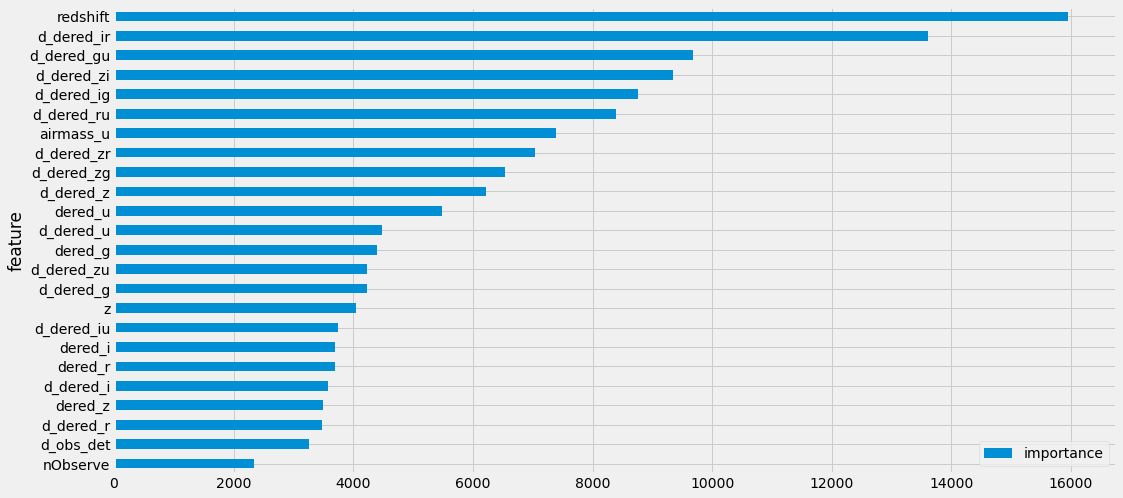

In [21]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [22]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [23]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [24]:
sub[target_col].value_counts()

2    40662
0    29977
1     9361
Name: class, dtype: int64

In [25]:
sub.to_csv(sub_file)